In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 245)
(2, 245)


[I 2025-06-08 06:18:07,296] A new study created in memory with name: no-name-1f42fc27-00a8-4f4c-bbbc-59dd84080fb8
[I 2025-06-08 06:23:20,027] Trial 0 finished with value: 2.4306942224502563 and parameters: {'lr': 0.02565353720917169, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4473712785601539}. Best is trial 0 with value: 2.4306942224502563.


Cross Validation Accuracies:
[2.669250726699829, 1.9529515504837036, 2.8094112873077393, 2.390897274017334, 2.330960273742676]
Mean Cross Validation Accuracy:
2.4306942224502563
Standard Deviation of Cross Validation Accuracy:
0.2966831775416879


[I 2025-06-08 06:28:36,643] Trial 1 finished with value: 0.08116127550601959 and parameters: {'lr': 0.009177650789116506, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3955323233589505}. Best is trial 1 with value: 0.08116127550601959.


Cross Validation Accuracies:
[0.06768588721752167, 0.0968945100903511, 0.08519930392503738, 0.0939062088727951, 0.0621204674243927]
Mean Cross Validation Accuracy:
0.08116127550601959
Standard Deviation of Cross Validation Accuracy:
0.0139313469014958


[I 2025-06-08 06:33:38,140] Trial 2 finished with value: 0.47235946655273436 and parameters: {'lr': 0.007433296589051253, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.24158369129430365}. Best is trial 1 with value: 0.08116127550601959.


Cross Validation Accuracies:
[0.43476787209510803, 0.4306354522705078, 0.5622084736824036, 0.4780348539352417, 0.45615068078041077]
Mean Cross Validation Accuracy:
0.47235946655273436
Standard Deviation of Cross Validation Accuracy:
0.04800375023273085


[I 2025-06-08 06:39:44,392] Trial 3 finished with value: 0.07679585069417953 and parameters: {'lr': 0.002047331763640069, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.44691358056195196}. Best is trial 3 with value: 0.07679585069417953.


Cross Validation Accuracies:
[0.05969643220305443, 0.097171351313591, 0.07398021221160889, 0.09469562768936157, 0.058435630053281784]
Mean Cross Validation Accuracy:
0.07679585069417953
Standard Deviation of Cross Validation Accuracy:
0.01657093043103191


[I 2025-06-08 06:44:15,268] Trial 4 finished with value: 0.07453594878315925 and parameters: {'lr': 0.0013423615240483373, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.41318106883797867}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.06065257266163826, 0.09184321016073227, 0.08913710713386536, 0.08471294492483139, 0.046333909034729004]
Mean Cross Validation Accuracy:
0.07453594878315925
Standard Deviation of Cross Validation Accuracy:
0.017913176996531315


[I 2025-06-08 06:49:10,227] Trial 5 finished with value: 1.5350826501846313 and parameters: {'lr': 0.01947569524890505, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.21200689920031857}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[1.6154124736785889, 1.8323363065719604, 1.4118962287902832, 1.5025475025177002, 1.313220739364624]
Mean Cross Validation Accuracy:
1.5350826501846313
Standard Deviation of Cross Validation Accuracy:
0.17903561349662614


[I 2025-06-08 06:54:34,189] Trial 6 finished with value: 0.17645612955093384 and parameters: {'lr': 0.0020835570659592877, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3936808242813944}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.1651640236377716, 0.16239893436431885, 0.18354949355125427, 0.20590509474277496, 0.1652631014585495]
Mean Cross Validation Accuracy:
0.17645612955093384
Standard Deviation of Cross Validation Accuracy:
0.01654060237147899


[I 2025-06-08 06:59:57,237] Trial 7 finished with value: 0.08627523332834244 and parameters: {'lr': 0.3989119417835458, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3055360410775266}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.043853744864463806, 0.09848938137292862, 0.09532444179058075, 0.10924401134252548, 0.08446458727121353]
Mean Cross Validation Accuracy:
0.08627523332834244
Standard Deviation of Cross Validation Accuracy:
0.022634042822032997


[I 2025-06-08 07:06:34,641] Trial 8 finished with value: 1.7003308534622192 and parameters: {'lr': 0.020874623410321876, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.49146691255597885}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[1.816596508026123, 1.4797803163528442, 1.7192869186401367, 1.6781048774719238, 1.8078856468200684]
Mean Cross Validation Accuracy:
1.7003308534622192
Standard Deviation of Cross Validation Accuracy:
0.1221323886939145


[I 2025-06-08 07:10:50,694] Trial 9 finished with value: 0.07633119970560073 and parameters: {'lr': 0.0018644997112228954, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15128789751944557}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.059568651020526886, 0.09715220332145691, 0.07254493236541748, 0.09453094750642776, 0.05785926431417465]
Mean Cross Validation Accuracy:
0.07633119970560073
Standard Deviation of Cross Validation Accuracy:
0.016740825950239333


[I 2025-06-08 07:15:51,925] Trial 10 finished with value: 0.07619498148560525 and parameters: {'lr': 0.23598641880445786, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3153894879385377}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05923963710665703, 0.09748443961143494, 0.07233089208602905, 0.0942012146115303, 0.05771872401237488]
Mean Cross Validation Accuracy:
0.07619498148560525
Standard Deviation of Cross Validation Accuracy:
0.01685972976527421


[I 2025-06-08 07:21:13,839] Trial 11 finished with value: 0.07685324847698212 and parameters: {'lr': 0.15746717097381108, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3350533835780582}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.059624142944812775, 0.09726288914680481, 0.0731058344244957, 0.09647056460380554, 0.05780281126499176]
Mean Cross Validation Accuracy:
0.07685324847698212
Standard Deviation of Cross Validation Accuracy:
0.017176710230881784


[I 2025-06-08 07:26:12,949] Trial 12 finished with value: 0.07638163566589355 and parameters: {'lr': 0.11450739949569287, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3479024973100468}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05929696932435036, 0.09684883803129196, 0.07270415872335434, 0.09498117864131927, 0.05807703360915184]
Mean Cross Validation Accuracy:
0.07638163566589355
Standard Deviation of Cross Validation Accuracy:
0.016764948485941244


[I 2025-06-08 07:31:23,733] Trial 13 finished with value: 0.08846568688750267 and parameters: {'lr': 0.7847225793636581, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2536011978071352}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05717052146792412, 0.16407740116119385, 0.07300957292318344, 0.09445615112781525, 0.0536147877573967]
Mean Cross Validation Accuracy:
0.08846568688750267
Standard Deviation of Cross Validation Accuracy:
0.04046203406877714


[I 2025-06-08 07:36:22,302] Trial 14 finished with value: 0.07641060277819633 and parameters: {'lr': 0.08007415797834208, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3802324221389213}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05983415246009827, 0.09713172167539597, 0.072784923017025, 0.0946650356054306, 0.057637181133031845]
Mean Cross Validation Accuracy:
0.07641060277819633
Standard Deviation of Cross Validation Accuracy:
0.016750848965601493


[I 2025-06-08 07:41:26,780] Trial 15 finished with value: 0.07694650292396546 and parameters: {'lr': 0.0010046947432810853, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.29184788657098953}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.047234341502189636, 0.11933726817369461, 0.07313917577266693, 0.0921374037861824, 0.05288432538509369]
Mean Cross Validation Accuracy:
0.07694650292396546
Standard Deviation of Cross Validation Accuracy:
0.026472767561274025


[I 2025-06-08 07:46:57,249] Trial 16 finished with value: 0.07546043246984482 and parameters: {'lr': 0.2902924107346331, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.13640668201930417}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.056449227035045624, 0.10289119929075241, 0.07041244208812714, 0.09055228531360626, 0.05699700862169266]
Mean Cross Validation Accuracy:
0.07546043246984482
Standard Deviation of Cross Validation Accuracy:
0.018482516873063157


[I 2025-06-08 07:52:23,230] Trial 17 finished with value: 0.07643328756093978 and parameters: {'lr': 0.046387266416199543, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.10171270440880203}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.059917815029621124, 0.09801837056875229, 0.07227861136198044, 0.09438013285398483, 0.05757150799036026]
Mean Cross Validation Accuracy:
0.07643328756093978
Standard Deviation of Cross Validation Accuracy:
0.016933953822109715


[I 2025-06-08 07:57:35,608] Trial 18 finished with value: 0.07614069432020187 and parameters: {'lr': 0.0058822487677397724, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1673232606576326}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05898141488432884, 0.09645260125398636, 0.07145548611879349, 0.09651802480220795, 0.057295944541692734]
Mean Cross Validation Accuracy:
0.07614069432020187
Standard Deviation of Cross Validation Accuracy:
0.01731661515263971


[I 2025-06-08 08:03:02,240] Trial 19 finished with value: 0.10381535738706589 and parameters: {'lr': 0.9598223216383724, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.12165060656004659}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.09442680329084396, 0.10133875161409378, 0.13099630177021027, 0.0876011922955513, 0.10471373796463013]
Mean Cross Validation Accuracy:
0.10381535738706589
Standard Deviation of Cross Validation Accuracy:
0.014810729212358365


[I 2025-06-08 08:08:24,745] Trial 20 finished with value: 0.11003035455942153 and parameters: {'lr': 0.31131471309479275, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.20537003529027154}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.08746474981307983, 0.1164870411157608, 0.09998760372400284, 0.1383156031370163, 0.10789677500724792]
Mean Cross Validation Accuracy:
0.11003035455942153
Standard Deviation of Cross Validation Accuracy:
0.017066690434873504


[I 2025-06-08 08:13:47,172] Trial 21 finished with value: 0.07632345482707023 and parameters: {'lr': 0.005092589530224733, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.16918180493882728}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.060331400483846664, 0.09733495116233826, 0.0703979879617691, 0.09562310576438904, 0.05792982876300812]
Mean Cross Validation Accuracy:
0.07632345482707023
Standard Deviation of Cross Validation Accuracy:
0.016989066743186777


[I 2025-06-08 08:18:52,443] Trial 22 finished with value: 0.08756760507822037 and parameters: {'lr': 0.003959200410215746, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.16029563756362128}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.0603187158703804, 0.0928526297211647, 0.06576425582170486, 0.15470124781131744, 0.06420117616653442]
Mean Cross Validation Accuracy:
0.08756760507822037
Standard Deviation of Cross Validation Accuracy:
0.035492916121500226


[I 2025-06-08 08:24:05,150] Trial 23 finished with value: 0.3278700590133667 and parameters: {'lr': 0.0010031141389757108, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.19697880201176246}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.2756573259830475, 0.2956322431564331, 0.29064464569091797, 0.4808228611946106, 0.29659321904182434]
Mean Cross Validation Accuracy:
0.3278700590133667
Standard Deviation of Cross Validation Accuracy:
0.07684266792928039


[I 2025-06-08 08:29:07,589] Trial 24 finished with value: 0.07602672278881073 and parameters: {'lr': 0.01290560074296549, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2736182207794432}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05988616496324539, 0.09640399366617203, 0.07363931834697723, 0.09152087569236755, 0.05868326127529144]
Mean Cross Validation Accuracy:
0.07602672278881073
Standard Deviation of Cross Validation Accuracy:
0.01563531200052231


[I 2025-06-08 08:34:11,164] Trial 25 finished with value: 0.07669370472431183 and parameters: {'lr': 0.05275190400695366, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2834696308227136}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05962567403912544, 0.09695539623498917, 0.07369279861450195, 0.09498634934425354, 0.05820830538868904]
Mean Cross Validation Accuracy:
0.07669370472431183
Standard Deviation of Cross Validation Accuracy:
0.01665647074030473


[I 2025-06-08 08:39:27,314] Trial 26 finished with value: 0.07723398208618164 and parameters: {'lr': 0.011981462589653932, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.45174348569511635}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.06161757558584213, 0.09748223423957825, 0.07296189665794373, 0.09748847782611847, 0.05661972612142563]
Mean Cross Validation Accuracy:
0.07723398208618164
Standard Deviation of Cross Validation Accuracy:
0.0173626422402648


[I 2025-06-08 08:44:40,047] Trial 27 finished with value: 0.10311115831136704 and parameters: {'lr': 0.00331668273015866, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23410439486294993}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05976778268814087, 0.09886177629232407, 0.06687107682228088, 0.22193579375743866, 0.0681193619966507]
Mean Cross Validation Accuracy:
0.10311115831136704
Standard Deviation of Cross Validation Accuracy:
0.060915956468757616


[I 2025-06-08 08:50:47,230] Trial 28 finished with value: 0.076236192882061 and parameters: {'lr': 0.013277568909850893, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.36123395078954157}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.059471093118190765, 0.09710410982370377, 0.07224787771701813, 0.09451805055141449, 0.057839833199977875]
Mean Cross Validation Accuracy:
0.076236192882061
Standard Deviation of Cross Validation Accuracy:
0.016763636567443275


[I 2025-06-08 08:55:33,633] Trial 29 finished with value: 0.07651234492659569 and parameters: {'lr': 0.034587468289372626, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4290812799144371}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05972110107541084, 0.09705992043018341, 0.07255477458238602, 0.09434843063354492, 0.05887749791145325]
Mean Cross Validation Accuracy:
0.07651234492659569
Standard Deviation of Cross Validation Accuracy:
0.01642513241814553


[I 2025-06-08 09:02:06,530] Trial 30 finished with value: 6.492718124389649 and parameters: {'lr': 0.07547922894273901, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2656568606403134}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[7.1291069984436035, 8.717286109924316, 6.562273979187012, 4.072269916534424, 5.982653617858887]
Mean Cross Validation Accuracy:
6.492718124389649
Standard Deviation of Cross Validation Accuracy:
1.5150753688152983


[I 2025-06-08 09:06:46,916] Trial 31 finished with value: 0.07644550725817681 and parameters: {'lr': 0.005222381906812971, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.13593066006704052}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.06020862236618996, 0.097654789686203, 0.07342058420181274, 0.09281203895807266, 0.05813150107860565]
Mean Cross Validation Accuracy:
0.07644550725817681
Standard Deviation of Cross Validation Accuracy:
0.016284265005417964


[I 2025-06-08 09:11:39,824] Trial 32 finished with value: 0.07656629383563995 and parameters: {'lr': 0.00819187056430915, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1819152472584194}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05936868488788605, 0.09636357426643372, 0.07318004965782166, 0.09662152081727982, 0.057297639548778534]
Mean Cross Validation Accuracy:
0.07656629383563995
Standard Deviation of Cross Validation Accuracy:
0.01716187567207525


[I 2025-06-08 09:16:51,485] Trial 33 finished with value: 0.07598724663257599 and parameters: {'lr': 0.01267460765382277, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.12016339495101333}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.06035488843917847, 0.09693837910890579, 0.07204364240169525, 0.09389540553092957, 0.05670391768217087]
Mean Cross Validation Accuracy:
0.07598724663257599
Standard Deviation of Cross Validation Accuracy:
0.016681855529859003


[I 2025-06-08 09:22:00,689] Trial 34 finished with value: 0.07608369886875152 and parameters: {'lr': 0.015767496050896956, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1010655757013294}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05887959897518158, 0.09628918021917343, 0.07214565575122833, 0.09455537796020508, 0.05854868143796921]
Mean Cross Validation Accuracy:
0.07608369886875152
Standard Deviation of Cross Validation Accuracy:
0.016543460811457408


[I 2025-06-08 09:28:00,586] Trial 35 finished with value: 0.17870852574706078 and parameters: {'lr': 0.027341323418811455, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.41578390378775054}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.04946913942694664, 0.19809366762638092, 0.14835479855537415, 0.24913135170936584, 0.24849367141723633]
Mean Cross Validation Accuracy:
0.17870852574706078
Standard Deviation of Cross Validation Accuracy:
0.07460468139364063


[I 2025-06-08 09:32:36,903] Trial 36 finished with value: 0.6187135934829712 and parameters: {'lr': 0.009012538656229932, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1334294074422718}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.5754345655441284, 0.5880002379417419, 0.5308013558387756, 0.7011382579803467, 0.6981935501098633]
Mean Cross Validation Accuracy:
0.6187135934829712
Standard Deviation of Cross Validation Accuracy:
0.06878347885715023


[I 2025-06-08 09:36:55,280] Trial 37 finished with value: 0.10508346259593963 and parameters: {'lr': 0.6233437380191857, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22374118433666396}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.10115712136030197, 0.11228076368570328, 0.11456266790628433, 0.10374803096055984, 0.09366872906684875]
Mean Cross Validation Accuracy:
0.10508346259593963
Standard Deviation of Cross Validation Accuracy:
0.007604632153943718


[I 2025-06-08 09:41:14,071] Trial 38 finished with value: 0.22703986167907714 and parameters: {'lr': 0.002037819427570689, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.48257216795777463}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.1910993754863739, 0.20469675958156586, 0.17365117371082306, 0.3614211976528168, 0.20433080196380615]
Mean Cross Validation Accuracy:
0.22703986167907714
Standard Deviation of Cross Validation Accuracy:
0.06814004639463953


[I 2025-06-08 09:46:55,927] Trial 39 finished with value: 3.8514545917510987 and parameters: {'lr': 0.04031081003298723, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18812150214648707}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[4.932290554046631, 3.6064555644989014, 4.312796592712402, 3.3523919582366943, 3.0533382892608643]
Mean Cross Validation Accuracy:
3.8514545917510987
Standard Deviation of Cross Validation Accuracy:
0.6822199772899981


[I 2025-06-08 09:51:16,890] Trial 40 finished with value: 0.0811470665037632 and parameters: {'lr': 0.022979217431991376, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.46921839641350105}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.06665709614753723, 0.10232821851968765, 0.08975435048341751, 0.0929228737950325, 0.0540727935731411]
Mean Cross Validation Accuracy:
0.0811470665037632
Standard Deviation of Cross Validation Accuracy:
0.017912965534692182


[I 2025-06-08 09:55:43,469] Trial 41 finished with value: 0.07663877755403518 and parameters: {'lr': 0.013566591929670382, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.11324700270702179}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05918514356017113, 0.09754876047372818, 0.07393669337034225, 0.0946039929986, 0.057919297367334366]
Mean Cross Validation Accuracy:
0.07663877755403518
Standard Deviation of Cross Validation Accuracy:
0.016866095509389827


[I 2025-06-08 10:00:24,635] Trial 42 finished with value: 0.07583444714546203 and parameters: {'lr': 0.017660587175480077, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.14406530408512946}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05778420343995094, 0.09621649980545044, 0.07255429774522781, 0.09454741328954697, 0.05806982144713402]
Mean Cross Validation Accuracy:
0.07583444714546203
Standard Deviation of Cross Validation Accuracy:
0.016838977265036647


[I 2025-06-08 10:05:01,995] Trial 43 finished with value: 0.07695272862911225 and parameters: {'lr': 0.018366395445900855, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1481448806536984}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.05971232429146767, 0.09681864827871323, 0.0735100582242012, 0.09664823114871979, 0.058074381202459335]
Mean Cross Validation Accuracy:
0.07695272862911225
Standard Deviation of Cross Validation Accuracy:
0.017017891207949394


[I 2025-06-08 10:09:52,882] Trial 44 finished with value: 0.14410914480686188 and parameters: {'lr': 0.0029508932220153657, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1311284456162791}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.061937592923641205, 0.09738936275243759, 0.1046878844499588, 0.3009263575077057, 0.1556045264005661]
Mean Cross Validation Accuracy:
0.14410914480686188
Standard Deviation of Cross Validation Accuracy:
0.08391986622901997


[I 2025-06-08 10:14:18,616] Trial 45 finished with value: 0.07695180103182793 and parameters: {'lr': 0.13500850565320055, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.31775476260479146}. Best is trial 4 with value: 0.07453594878315925.


Cross Validation Accuracies:
[0.062296751886606216, 0.09739961475133896, 0.07259804755449295, 0.09480146318674088, 0.05766312777996063]
Mean Cross Validation Accuracy:
0.07695180103182793
Standard Deviation of Cross Validation Accuracy:
0.01638598227485875


[I 2025-06-08 10:18:48,039] Trial 46 finished with value: 0.07242001667618751 and parameters: {'lr': 0.0014136507771366866, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21743619058495}. Best is trial 46 with value: 0.07242001667618751.


Cross Validation Accuracies:
[0.05332938954234123, 0.08843497931957245, 0.06825906038284302, 0.10403662919998169, 0.04804002493619919]
Mean Cross Validation Accuracy:
0.07242001667618751
Standard Deviation of Cross Validation Accuracy:
0.02112931051799525


[I 2025-06-08 10:23:08,757] Trial 47 finished with value: 0.06672966554760933 and parameters: {'lr': 0.0018340492826592278, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14569832363832508}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.0545680895447731, 0.08721240609884262, 0.07280337810516357, 0.07105739414691925, 0.0480070598423481]
Mean Cross Validation Accuracy:
0.06672966554760933
Standard Deviation of Cross Validation Accuracy:
0.013954223552872128


[I 2025-06-08 10:27:23,208] Trial 48 finished with value: 0.08024183288216591 and parameters: {'lr': 0.0015816259935381577, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22402992052330442}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06572514772415161, 0.10453205555677414, 0.07112526148557663, 0.10135278850793839, 0.05847391113638878]
Mean Cross Validation Accuracy:
0.08024183288216591
Standard Deviation of Cross Validation Accuracy:
0.01899144967690295


[I 2025-06-08 10:31:46,345] Trial 49 finished with value: 0.07811301052570344 and parameters: {'lr': 0.0012485309795025902, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14844487169017995}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.056704629212617874, 0.10634882003068924, 0.07481324672698975, 0.0963083803653717, 0.05638997629284859]
Mean Cross Validation Accuracy:
0.07811301052570344
Standard Deviation of Cross Validation Accuracy:
0.020344187719639792


[I 2025-06-08 10:35:58,254] Trial 50 finished with value: 0.07759166657924652 and parameters: {'lr': 0.002617611731407444, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16968969884686214}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.0671985000371933, 0.09800153225660324, 0.07350405305624008, 0.09525559097528458, 0.05399865657091141]
Mean Cross Validation Accuracy:
0.07759166657924652
Standard Deviation of Cross Validation Accuracy:
0.016792459369457547


[I 2025-06-08 10:40:33,233] Trial 51 finished with value: 0.0709361493587494 and parameters: {'lr': 0.001440774408680318, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11763592783096012}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06513509154319763, 0.08926737308502197, 0.06684388220310211, 0.09143370389938354, 0.04200069606304169]
Mean Cross Validation Accuracy:
0.0709361493587494
Standard Deviation of Cross Validation Accuracy:
0.018131976644202782


[I 2025-06-08 10:44:55,927] Trial 52 finished with value: 0.08097760602831841 and parameters: {'lr': 0.0014709133025305428, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18457406473207905}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.061078671365976334, 0.09595774859189987, 0.07079929113388062, 0.11637775599956512, 0.06067456305027008]
Mean Cross Validation Accuracy:
0.08097760602831841
Standard Deviation of Cross Validation Accuracy:
0.02186025863601323


[I 2025-06-08 10:49:20,504] Trial 53 finished with value: 0.07672435715794564 and parameters: {'lr': 0.002095452102283728, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1434527002159}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06404244899749756, 0.09948880225419998, 0.07470916956663132, 0.09241899102926254, 0.052962373942136765]
Mean Cross Validation Accuracy:
0.07672435715794564
Standard Deviation of Cross Validation Accuracy:
0.017286209039935135


[I 2025-06-08 10:53:32,388] Trial 54 finished with value: 0.07263791263103485 and parameters: {'lr': 0.004175004312346565, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11397010735725584}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.054663725197315216, 0.08761574327945709, 0.06769727915525436, 0.09877078980207443, 0.05444202572107315]
Mean Cross Validation Accuracy:
0.07263791263103485
Standard Deviation of Cross Validation Accuracy:
0.017809178833702925


[I 2025-06-08 10:57:50,368] Trial 55 finished with value: 0.08241884112358093 and parameters: {'lr': 0.0013139735810907274, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11223041186536517}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.08208868652582169, 0.08477479219436646, 0.08463091403245926, 0.10269090533256531, 0.057908907532691956]
Mean Cross Validation Accuracy:
0.08241884112358093
Standard Deviation of Cross Validation Accuracy:
0.014298574795996442


[I 2025-06-08 11:02:22,248] Trial 56 finished with value: 0.07120950520038605 and parameters: {'lr': 0.003887200964893583, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16068515202461317}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.051824066787958145, 0.08844590187072754, 0.07287612557411194, 0.09360422939062119, 0.04929720237851143]
Mean Cross Validation Accuracy:
0.07120950520038605
Standard Deviation of Cross Validation Accuracy:
0.018206256631190004


[I 2025-06-08 11:06:33,469] Trial 57 finished with value: 0.07936085760593414 and parameters: {'lr': 0.003892327870651292, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15980956428754645}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.07208625227212906, 0.09553622454404831, 0.08290735632181168, 0.09176046401262283, 0.05451399087905884]
Mean Cross Validation Accuracy:
0.07936085760593414
Standard Deviation of Cross Validation Accuracy:
0.014820641394156203


[I 2025-06-08 11:10:41,043] Trial 58 finished with value: 0.07328198775649071 and parameters: {'lr': 0.002538730245979759, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21270240702184962}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.04154432564973831, 0.09506697207689285, 0.07183518260717392, 0.10506604611873627, 0.052897412329912186]
Mean Cross Validation Accuracy:
0.07328198775649071
Standard Deviation of Cross Validation Accuracy:
0.024123495867221005


[I 2025-06-08 11:14:42,587] Trial 59 finished with value: 0.07796415686607361 and parameters: {'lr': 0.0025591688729913412, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21016254635365741}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05113410949707031, 0.08433245867490768, 0.08312959223985672, 0.09632182121276855, 0.07490280270576477]
Mean Cross Validation Accuracy:
0.07796415686607361
Standard Deviation of Cross Validation Accuracy:
0.015056322007136039


[I 2025-06-08 11:19:11,821] Trial 60 finished with value: 0.0735468715429306 and parameters: {'lr': 0.004266415166323828, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1965674633208634}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05290650203824043, 0.09905461966991425, 0.08048446476459503, 0.09202143549919128, 0.04326733574271202]
Mean Cross Validation Accuracy:
0.0735468715429306
Standard Deviation of Cross Validation Accuracy:
0.02183098746809109


[I 2025-06-08 11:23:44,394] Trial 61 finished with value: 0.077741439640522 and parameters: {'lr': 0.006479697441236349, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2436371768991056}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.060752905905246735, 0.09503500163555145, 0.06828992068767548, 0.10700944811105728, 0.05761992186307907]
Mean Cross Validation Accuracy:
0.077741439640522
Standard Deviation of Cross Validation Accuracy:
0.019690101944712254


[I 2025-06-08 11:28:38,055] Trial 62 finished with value: 0.07053744345903397 and parameters: {'lr': 0.004146842108600541, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1994446069008934}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.057644329965114594, 0.09477130323648453, 0.07226277142763138, 0.09554912149906158, 0.03245969116687775]
Mean Cross Validation Accuracy:
0.07053744345903397
Standard Deviation of Cross Validation Accuracy:
0.023799110697167888


[I 2025-06-08 11:33:04,877] Trial 63 finished with value: 0.07135208249092102 and parameters: {'lr': 0.001866541864381341, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17482629851248643}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.04747313633561134, 0.09599396586418152, 0.0748930498957634, 0.08883707225322723, 0.04956318810582161]
Mean Cross Validation Accuracy:
0.07135208249092102
Standard Deviation of Cross Validation Accuracy:
0.01985167862597356


[I 2025-06-08 11:37:51,468] Trial 64 finished with value: 0.07611290290951729 and parameters: {'lr': 0.0017212137496272135, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17563703245866313}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05093209818005562, 0.09603685140609741, 0.08805152773857117, 0.09460393339395523, 0.05094010382890701]
Mean Cross Validation Accuracy:
0.07611290290951729
Standard Deviation of Cross Validation Accuracy:
0.02073236810041605


[I 2025-06-08 11:42:01,874] Trial 65 finished with value: 0.0749586969614029 and parameters: {'lr': 0.0011692919728858884, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12486213057367632}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.052558355033397675, 0.08478017151355743, 0.09174695611000061, 0.09703556448221207, 0.04867243766784668]
Mean Cross Validation Accuracy:
0.0749586969614029
Standard Deviation of Cross Validation Accuracy:
0.020290085427568175


[I 2025-06-08 11:46:13,229] Trial 66 finished with value: 0.07236266806721688 and parameters: {'lr': 0.002058507567657647, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15840675786615388}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05955811217427254, 0.08957970142364502, 0.06599327176809311, 0.0926913321018219, 0.0539909228682518]
Mean Cross Validation Accuracy:
0.07236266806721688
Standard Deviation of Cross Validation Accuracy:
0.0158223114715564


[I 2025-06-08 11:51:08,518] Trial 67 finished with value: 0.07624031379818916 and parameters: {'lr': 0.0018885223357551096, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15554771095445902}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05343089625239372, 0.1034897044301033, 0.07487177848815918, 0.09430775791406631, 0.0551014319062233]
Mean Cross Validation Accuracy:
0.07624031379818916
Standard Deviation of Cross Validation Accuracy:
0.020188890866051638


[I 2025-06-08 11:55:32,342] Trial 68 finished with value: 0.07884076312184334 and parameters: {'lr': 0.0032858071806142713, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19783596639871762}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05109972134232521, 0.09390062838792801, 0.08019906282424927, 0.10614059120416641, 0.06286381185054779]
Mean Cross Validation Accuracy:
0.07884076312184334
Standard Deviation of Cross Validation Accuracy:
0.01999376654948686


[I 2025-06-08 11:59:55,153] Trial 69 finished with value: 0.07399414032697678 and parameters: {'lr': 0.002257794211909267, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16660863932262515}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.058237917721271515, 0.08029691874980927, 0.07845364511013031, 0.0987367257475853, 0.054245494306087494]
Mean Cross Validation Accuracy:
0.07399414032697678
Standard Deviation of Cross Validation Accuracy:
0.016186879270034264


[I 2025-06-08 12:04:01,704] Trial 70 finished with value: 0.07406310588121415 and parameters: {'lr': 0.001030170112693669, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17687695317583063}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05388445034623146, 0.08760129660367966, 0.07200827449560165, 0.10545756667852402, 0.05136394128203392]
Mean Cross Validation Accuracy:
0.07406310588121415
Standard Deviation of Cross Validation Accuracy:
0.020472163156418716


[I 2025-06-08 12:08:12,009] Trial 71 finished with value: 0.07842043191194534 and parameters: {'lr': 0.0036185740636047107, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10776190383524326}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06387480348348618, 0.09761541336774826, 0.07360907644033432, 0.10174156725406647, 0.05526129901409149]
Mean Cross Validation Accuracy:
0.07842043191194534
Standard Deviation of Cross Validation Accuracy:
0.018348801329610642


[I 2025-06-08 12:12:56,730] Trial 72 finished with value: 0.07700071334838868 and parameters: {'lr': 0.004703686589300818, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13142516637701918}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05635689198970795, 0.09641802310943604, 0.07371681928634644, 0.107956163585186, 0.05055566877126694]
Mean Cross Validation Accuracy:
0.07700071334838868
Standard Deviation of Cross Validation Accuracy:
0.022233144271133112


[I 2025-06-08 12:17:43,629] Trial 73 finished with value: 0.07485634237527847 and parameters: {'lr': 0.001637182903491312, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15581099828459113}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.048432450741529465, 0.09933336824178696, 0.08030322194099426, 0.09631604701280594, 0.04989662393927574]
Mean Cross Validation Accuracy:
0.07485634237527847
Standard Deviation of Cross Validation Accuracy:
0.02195687504577872


[I 2025-06-08 12:22:02,210] Trial 74 finished with value: 0.07554460018873214 and parameters: {'lr': 0.006037284652328805, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1186438761259731}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.059580035507678986, 0.09583248198032379, 0.07196933776140213, 0.09286554902791977, 0.05747559666633606]
Mean Cross Validation Accuracy:
0.07554460018873214
Standard Deviation of Cross Validation Accuracy:
0.016160149327599176


[I 2025-06-08 12:26:41,954] Trial 75 finished with value: 0.0739372730255127 and parameters: {'lr': 0.0027686381724907724, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19149983043587007}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05871406942605972, 0.09493938833475113, 0.07521694898605347, 0.08473017811775208, 0.05608578026294708]
Mean Cross Validation Accuracy:
0.0739372730255127
Standard Deviation of Cross Validation Accuracy:
0.014897214102233682


[I 2025-06-08 12:31:18,453] Trial 76 finished with value: 0.07275355979800224 and parameters: {'lr': 0.007198810074627168, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10011315307357439}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.045828770846128464, 0.10039772838354111, 0.07765808701515198, 0.09514998644590378, 0.04473322629928589]
Mean Cross Validation Accuracy:
0.07275355979800224
Standard Deviation of Cross Validation Accuracy:
0.02366405595026567


[I 2025-06-08 12:37:11,915] Trial 77 finished with value: 0.1022365540266037 and parameters: {'lr': 0.001396931112317233, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.140004656452259}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.07152742892503738, 0.11830586940050125, 0.10558576881885529, 0.13908372819423676, 0.07667997479438782]
Mean Cross Validation Accuracy:
0.1022365540266037
Standard Deviation of Cross Validation Accuracy:
0.02539032684707497


[I 2025-06-08 12:41:40,714] Trial 78 finished with value: 0.0728187009692192 and parameters: {'lr': 0.0032033965509544377, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22042023578532519}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06192020699381828, 0.09469272196292877, 0.06576235592365265, 0.09495507925748825, 0.046763140708208084]
Mean Cross Validation Accuracy:
0.0728187009692192
Standard Deviation of Cross Validation Accuracy:
0.019057562462202346


[I 2025-06-08 12:46:17,086] Trial 79 finished with value: 0.07586695030331611 and parameters: {'lr': 0.0021436006472875207, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.23988921045098308}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06111043691635132, 0.09303218126296997, 0.07239685207605362, 0.09483735263347626, 0.057957928627729416]
Mean Cross Validation Accuracy:
0.07586695030331611
Standard Deviation of Cross Validation Accuracy:
0.015524500925244331


[I 2025-06-08 12:50:43,109] Trial 80 finished with value: 0.07762703821063041 and parameters: {'lr': 0.010674598207411951, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.16512435189154004}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06048772856593132, 0.09752198308706284, 0.07136397063732147, 0.09559965133666992, 0.06316185742616653]
Mean Cross Validation Accuracy:
0.07762703821063041
Standard Deviation of Cross Validation Accuracy:
0.015881102353844993


[I 2025-06-08 12:55:31,350] Trial 81 finished with value: 0.0788007251918316 and parameters: {'lr': 0.006821425617407306, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10164589610516339}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06002504751086235, 0.09832198172807693, 0.07704997807741165, 0.10232377052307129, 0.05628284811973572]
Mean Cross Validation Accuracy:
0.0788007251918316
Standard Deviation of Cross Validation Accuracy:
0.018958159689599498


[I 2025-06-08 13:00:04,227] Trial 82 finished with value: 0.06880060657858848 and parameters: {'lr': 0.004313856580738076, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12658241866495692}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05392530933022499, 0.09387191385030746, 0.06413383781909943, 0.09110011160373688, 0.04097186028957367]
Mean Cross Validation Accuracy:
0.06880060657858848
Standard Deviation of Cross Validation Accuracy:
0.02070425411155706


[I 2025-06-08 13:05:01,446] Trial 83 finished with value: 0.07720066606998444 and parameters: {'lr': 0.004918966526321782, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1249743092702672}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05548412352800369, 0.10239001363515854, 0.07292929291725159, 0.09556455910205841, 0.05963534116744995]
Mean Cross Validation Accuracy:
0.07720066606998444
Standard Deviation of Cross Validation Accuracy:
0.018815574854740644


[I 2025-06-08 13:09:51,666] Trial 84 finished with value: 0.06963147968053818 and parameters: {'lr': 0.0017931563894363768, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1508347495849249}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05190970003604889, 0.09021037817001343, 0.07115904241800308, 0.09273337572813034, 0.04214490205049515]
Mean Cross Validation Accuracy:
0.06963147968053818
Standard Deviation of Cross Validation Accuracy:
0.020144952397714865


[I 2025-06-08 13:14:37,337] Trial 85 finished with value: 0.07834079638123512 and parameters: {'lr': 0.0017649508438697878, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17794440436369624}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.058371562510728836, 0.09399547427892685, 0.07778490334749222, 0.10068835318088531, 0.060863688588142395]
Mean Cross Validation Accuracy:
0.07834079638123512
Standard Deviation of Cross Validation Accuracy:
0.01702357688763082


[I 2025-06-08 13:20:53,327] Trial 86 finished with value: 0.08127449676394463 and parameters: {'lr': 0.0011807008686294316, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15331528480938414}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.07209587097167969, 0.09506580978631973, 0.08936383575201035, 0.1101028099656105, 0.03974415734410286]
Mean Cross Validation Accuracy:
0.08127449676394463
Standard Deviation of Cross Validation Accuracy:
0.024065434240669793


[I 2025-06-08 13:26:17,064] Trial 87 finished with value: 0.09798365980386733 and parameters: {'lr': 0.002337353362773341, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20126806945409906}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.08656077831983566, 0.10785109549760818, 0.07211439311504364, 0.138710618019104, 0.08468141406774521]
Mean Cross Validation Accuracy:
0.09798365980386733
Standard Deviation of Cross Validation Accuracy:
0.023378204955366615


[I 2025-06-08 13:30:59,926] Trial 88 finished with value: 0.07418179512023926 and parameters: {'lr': 0.0014535872349622702, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14800109727023958}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05556444451212883, 0.08443489670753479, 0.08411400765180588, 0.09738333523273468, 0.04941229149699211]
Mean Cross Validation Accuracy:
0.07418179512023926
Standard Deviation of Cross Validation Accuracy:
0.018451127092569214


[I 2025-06-08 13:35:32,123] Trial 89 finished with value: 0.07851052135229111 and parameters: {'lr': 0.0019218175564725834, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1344454398182699}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06176551803946495, 0.09908278286457062, 0.08450139313936234, 0.09529414772987366, 0.051908764988183975]
Mean Cross Validation Accuracy:
0.07851052135229111
Standard Deviation of Cross Validation Accuracy:
0.018594876608802227


[I 2025-06-08 13:40:11,688] Trial 90 finished with value: 0.07312001511454583 and parameters: {'lr': 0.0030305149401888528, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18775271708714314}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.04737253859639168, 0.09588530659675598, 0.07096569240093231, 0.10003577172756195, 0.05134076625108719]
Mean Cross Validation Accuracy:
0.07312001511454583
Standard Deviation of Cross Validation Accuracy:
0.021838616186859765


[I 2025-06-08 13:45:10,340] Trial 91 finished with value: 0.07557689025998116 and parameters: {'lr': 0.0037951969597782593, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1147643407531472}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05198217183351517, 0.0970010906457901, 0.07745087891817093, 0.1033652201294899, 0.04808508977293968]
Mean Cross Validation Accuracy:
0.07557689025998116
Standard Deviation of Cross Validation Accuracy:
0.02257081878994406


[I 2025-06-08 13:50:13,075] Trial 92 finished with value: 0.079468035697937 and parameters: {'lr': 0.0016559904652226822, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12489942128389935}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06324411183595657, 0.09008655697107315, 0.07166467607021332, 0.09871703386306763, 0.07362779974937439]
Mean Cross Validation Accuracy:
0.079468035697937
Standard Deviation of Cross Validation Accuracy:
0.012972998167602246


[I 2025-06-08 13:55:16,763] Trial 93 finished with value: 0.07186021581292153 and parameters: {'lr': 0.00108297197112987, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14006679793408672}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05538659915328026, 0.09393765032291412, 0.07798003405332565, 0.090277299284935, 0.04171949625015259]
Mean Cross Validation Accuracy:
0.07186021581292153
Standard Deviation of Cross Validation Accuracy:
0.020218295057021992


[I 2025-06-08 14:00:43,316] Trial 94 finished with value: 0.08190098404884338 and parameters: {'lr': 0.0012735623659093146, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17177485264254866}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.07436977326869965, 0.0984048917889595, 0.06983258575201035, 0.09553367644548416, 0.07136399298906326]
Mean Cross Validation Accuracy:
0.08190098404884338
Standard Deviation of Cross Validation Accuracy:
0.01242274387191118


[I 2025-06-08 14:05:22,016] Trial 95 finished with value: 0.07592116221785546 and parameters: {'lr': 0.0011788869987547162, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16004815475606926}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.062380630522966385, 0.09795509278774261, 0.07040463387966156, 0.09158068895339966, 0.05728476494550705]
Mean Cross Validation Accuracy:
0.07592116221785546
Standard Deviation of Cross Validation Accuracy:
0.016073632201335317


[I 2025-06-08 14:09:42,009] Trial 96 finished with value: 0.07653147727251053 and parameters: {'lr': 0.0022670095728555923, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14154584478588056}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.059830185025930405, 0.09735965728759766, 0.07246606796979904, 0.09466677904129028, 0.05833469703793526]
Mean Cross Validation Accuracy:
0.07653147727251053
Standard Deviation of Cross Validation Accuracy:
0.01666904783960536


[I 2025-06-08 14:13:38,994] Trial 97 finished with value: 0.07354469373822212 and parameters: {'lr': 0.00102638923833368, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16533289477587831}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.05152575299143791, 0.10070251673460007, 0.07226859778165817, 0.09898117929697037, 0.04424542188644409]
Mean Cross Validation Accuracy:
0.07354469373822212
Standard Deviation of Cross Validation Accuracy:
0.02336438165682177


[I 2025-06-08 14:18:16,874] Trial 98 finished with value: 0.07458994686603546 and parameters: {'lr': 0.0014419150280643857, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2546128282476474}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.051460523158311844, 0.1001846194267273, 0.07676204293966293, 0.08948364853858948, 0.05505890026688576]
Mean Cross Validation Accuracy:
0.07458994686603546
Standard Deviation of Cross Validation Accuracy:
0.018963436590780175


[I 2025-06-08 14:21:54,902] Trial 99 finished with value: 0.07235749065876007 and parameters: {'lr': 0.0019681967989825413, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15023295617786936}. Best is trial 47 with value: 0.06672966554760933.


Cross Validation Accuracies:
[0.06022690609097481, 0.09703952819108963, 0.07146875560283661, 0.09233254939317703, 0.040719714015722275]
Mean Cross Validation Accuracy:
0.07235749065876007
Standard Deviation of Cross Validation Accuracy:
0.020770632109116456
Number of finished trials: 100
Best trial: {'lr': 0.0018340492826592278, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14569832363832508}
Best hyperparameters:  {'lr': 0.0018340492826592278, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14569832363832508}
Fold 1:
Epoch 1/100
19/19 [==============================] - 14s 182ms/step - loss: 0.1609 - val_loss: 0.1057
Epoch 2/100
19/19 [==============================] - 2s 131ms/step - loss: 0.1158 - val_loss: 0.1056
Epoch 3/100
19/19 [==============================] - 2s 100ms/step - loss: 0.0913 - val_loss: 0.0839
Epoch 4/100
19/19 [==============================] - 3s 

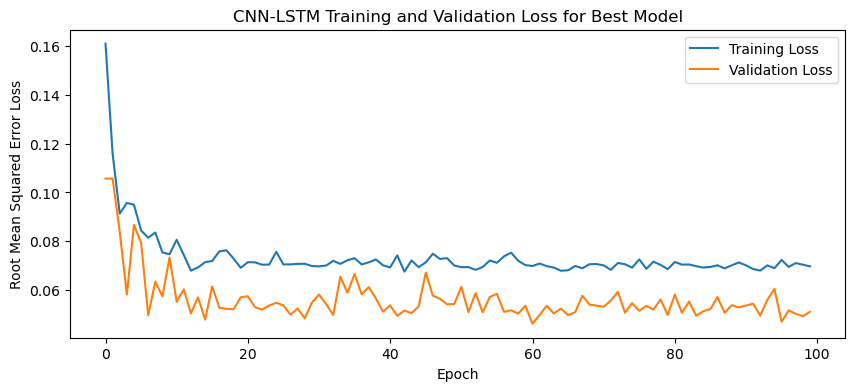

1/1 - 3s - loss: 0.0586 - 3s/epoch - 3s/step
Test Loss: 0.05855279788374901
Fold 2:
Epoch 1/100
19/19 [==============================] - 17s 349ms/step - loss: 0.1647 - val_loss: 0.1245
Epoch 2/100
19/19 [==============================] - 3s 177ms/step - loss: 0.0916 - val_loss: 0.0600
Epoch 3/100
19/19 [==============================] - 3s 136ms/step - loss: 0.0902 - val_loss: 0.0925
Epoch 4/100
19/19 [==============================] - 3s 154ms/step - loss: 0.1017 - val_loss: 0.0811
Epoch 5/100
19/19 [==============================] - 3s 158ms/step - loss: 0.0791 - val_loss: 0.0855
Epoch 6/100
19/19 [==============================] - 3s 143ms/step - loss: 0.0822 - val_loss: 0.0712
Epoch 7/100
19/19 [==============================] - 3s 133ms/step - loss: 0.0703 - val_loss: 0.0620
Epoch 8/100
19/19 [==============================] - 2s 109ms/step - loss: 0.0791 - val_loss: 0.0667
Epoch 9/100
19/19 [==============================] - 2s 96ms/step - loss: 0.0718 - val_loss: 0.0738
Epoch 1

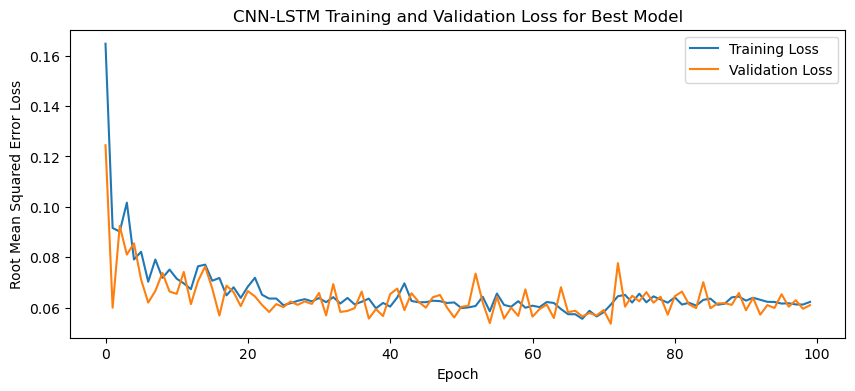

1/1 - 3s - loss: 0.0970 - 3s/epoch - 3s/step
Test Loss: 0.09695786982774734
Fold 3:
Epoch 1/100
19/19 [==============================] - 19s 471ms/step - loss: 0.1794 - val_loss: 0.1502
Epoch 2/100
19/19 [==============================] - 4s 229ms/step - loss: 0.0996 - val_loss: 0.0758
Epoch 3/100
19/19 [==============================] - 3s 183ms/step - loss: 0.0830 - val_loss: 0.0844
Epoch 4/100
19/19 [==============================] - 6s 338ms/step - loss: 0.0916 - val_loss: 0.0703
Epoch 5/100
19/19 [==============================] - 3s 171ms/step - loss: 0.0820 - val_loss: 0.0982
Epoch 6/100
19/19 [==============================] - 5s 250ms/step - loss: 0.0898 - val_loss: 0.0764
Epoch 7/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0740 - val_loss: 0.0645
Epoch 8/100
19/19 [==============================] - 4s 193ms/step - loss: 0.0765 - val_loss: 0.0704
Epoch 9/100
19/19 [==============================] - 3s 185ms/step - loss: 0.0693 - val_loss: 0.0647
Epoch 

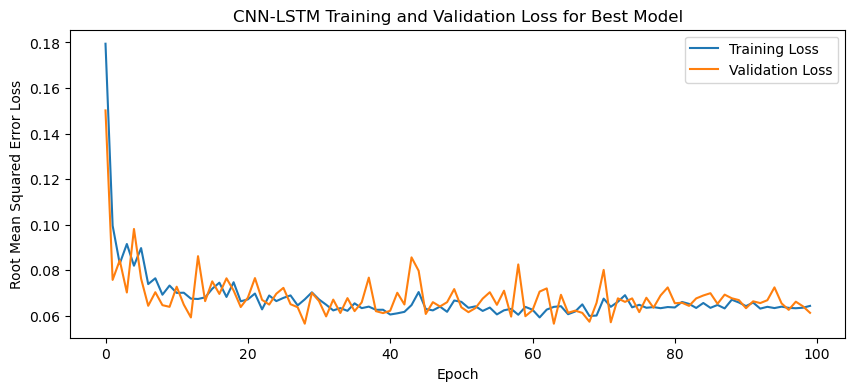

1/1 - 5s - loss: 0.0746 - 5s/epoch - 5s/step
Test Loss: 0.07464294880628586
Fold 4:
Epoch 1/100
20/20 [==============================] - 21s 289ms/step - loss: 0.2522 - val_loss: 0.0954
Epoch 2/100
20/20 [==============================] - 4s 182ms/step - loss: 0.1258 - val_loss: 0.1180
Epoch 3/100
20/20 [==============================] - 2s 100ms/step - loss: 0.1221 - val_loss: 0.1155
Epoch 4/100
20/20 [==============================] - 2s 100ms/step - loss: 0.1281 - val_loss: 0.1560
Epoch 5/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1312 - val_loss: 0.1279
Epoch 6/100
20/20 [==============================] - 2s 121ms/step - loss: 0.1253 - val_loss: 0.0627
Epoch 7/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1182 - val_loss: 0.0913
Epoch 8/100
20/20 [==============================] - 4s 188ms/step - loss: 0.1081 - val_loss: 0.0896
Epoch 9/100
20/20 [==============================] - 4s 185ms/step - loss: 0.1072 - val_loss: 0.0634
Epoch 

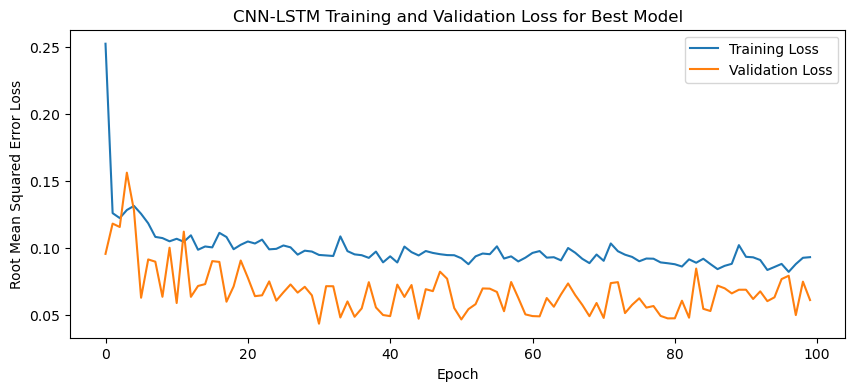

1/1 - 4s - loss: 0.0964 - 4s/epoch - 4s/step
Test Loss: 0.09643324464559555
Fold 5:
Epoch 1/100
19/19 [==============================] - 15s 271ms/step - loss: 0.2414 - val_loss: 0.1252
Epoch 2/100
19/19 [==============================] - 2s 118ms/step - loss: 0.0933 - val_loss: 0.1238
Epoch 3/100
19/19 [==============================] - 2s 107ms/step - loss: 0.0988 - val_loss: 0.0990
Epoch 4/100
19/19 [==============================] - 2s 116ms/step - loss: 0.0963 - val_loss: 0.0870
Epoch 5/100
19/19 [==============================] - 3s 150ms/step - loss: 0.0936 - val_loss: 0.0707
Epoch 6/100
19/19 [==============================] - 3s 149ms/step - loss: 0.0926 - val_loss: 0.1098
Epoch 7/100
19/19 [==============================] - 3s 174ms/step - loss: 0.0773 - val_loss: 0.1083
Epoch 8/100
19/19 [==============================] - 3s 170ms/step - loss: 0.0818 - val_loss: 0.0784
Epoch 9/100
19/19 [==============================] - 3s 155ms/step - loss: 0.0689 - val_loss: 0.0621
Epoch 

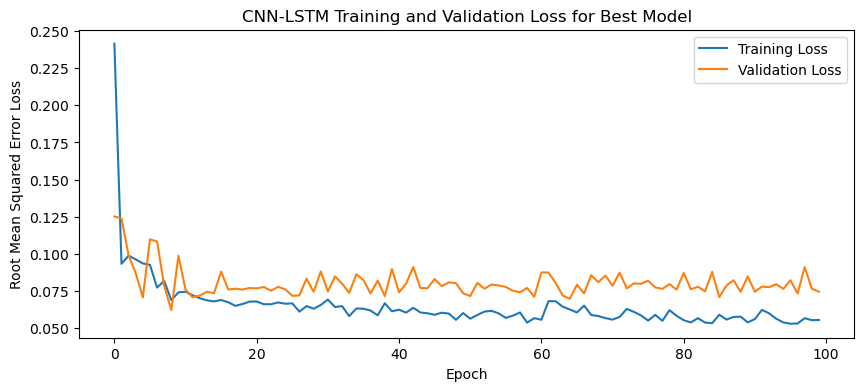

1/1 - 4s - loss: 0.0525 - 4s/epoch - 4s/step
Test Loss: 0.05252347141504288


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

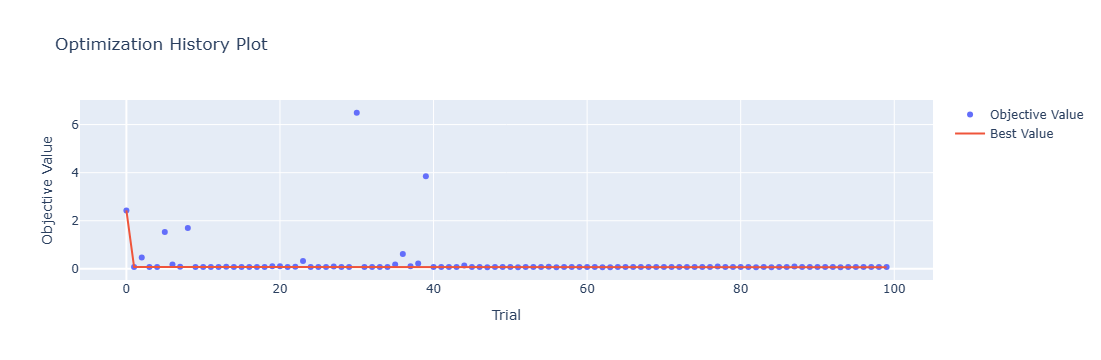

In [4]:
optuna.visualization.plot_optimization_history(study)

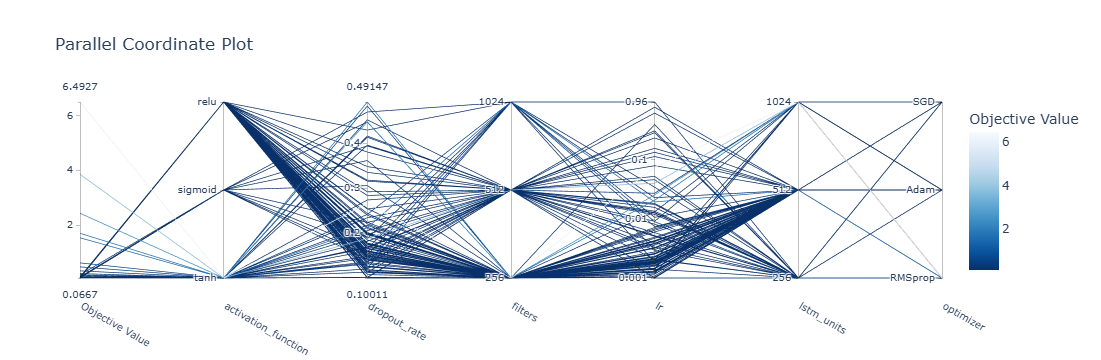

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

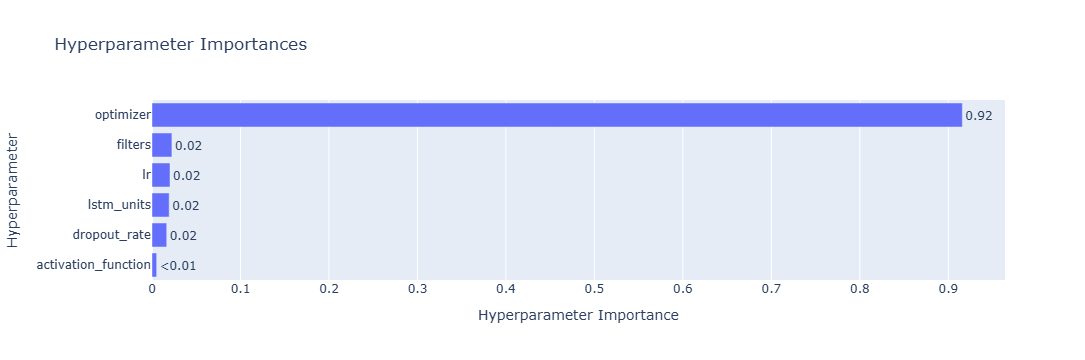

In [6]:
optuna.visualization.plot_param_importances(study)

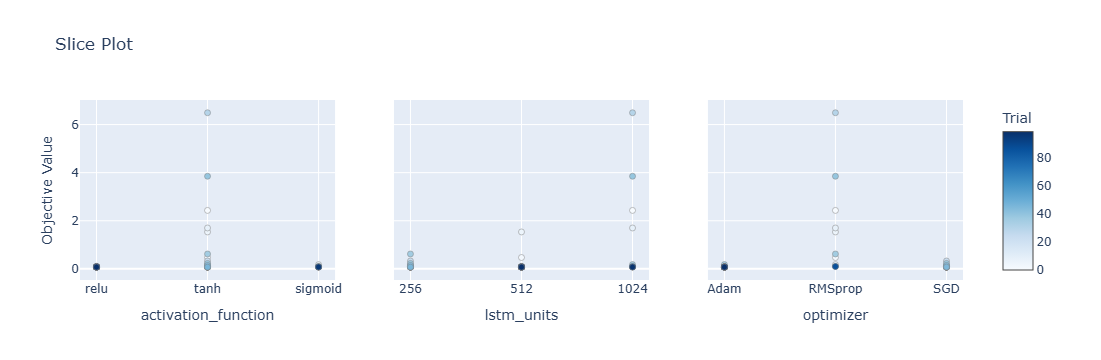

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

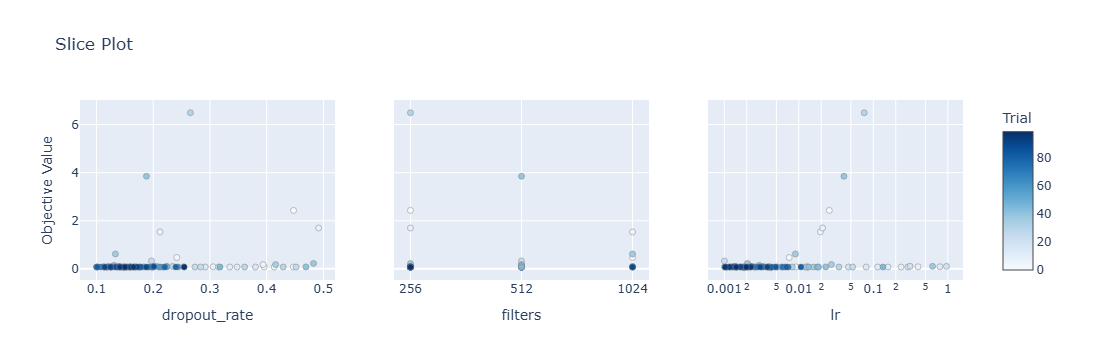

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 27s 435ms/step - loss: 0.1766 - accuracy: 0.1053 - mae: 0.1545 - rmse: 0.1766 - mape: 39.5172 - pearson: 0.2677 - val_loss: 0.0814 - val_accuracy: 0.0000e+00 - val_mae: 0.0631 - val_rmse: 0.0814 - val_mape: 13.4704 - val_pearson: 0.5655
Epoch 2/100
19/19 [==============================] - 2s 119ms/step - loss: 0.1096 - accuracy: 0.1579 - mae: 0.0912 - rmse: 0.1096 - mape: 23.3609 - pearson: 0.2166 - val_loss: 0.0642 - val_accuracy: 0.6667 - val_mae: 0.0591 - val_rmse: 0.0642 - val_mape: 14.0416 - val_pearson: 0.2477
Epoch 3/100
19/19 [==============================] - 3s 135ms/step - loss: 0.1014 - ac

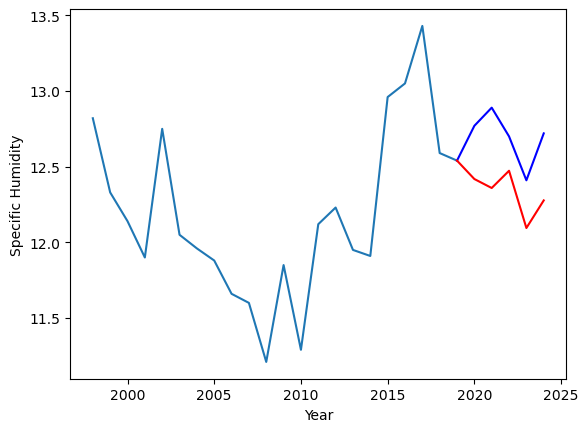

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.67		-0.21
10.09		9.61		-0.48
9.65		9.72		0.07
9.13		9.34		0.21
9.32		9.53		0.21


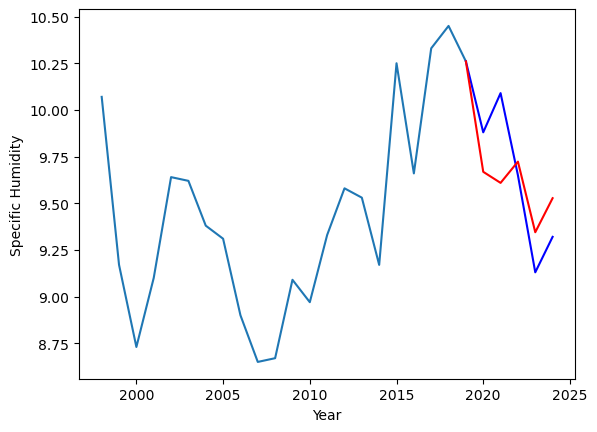

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.418444
1                1    9.88   9.668444


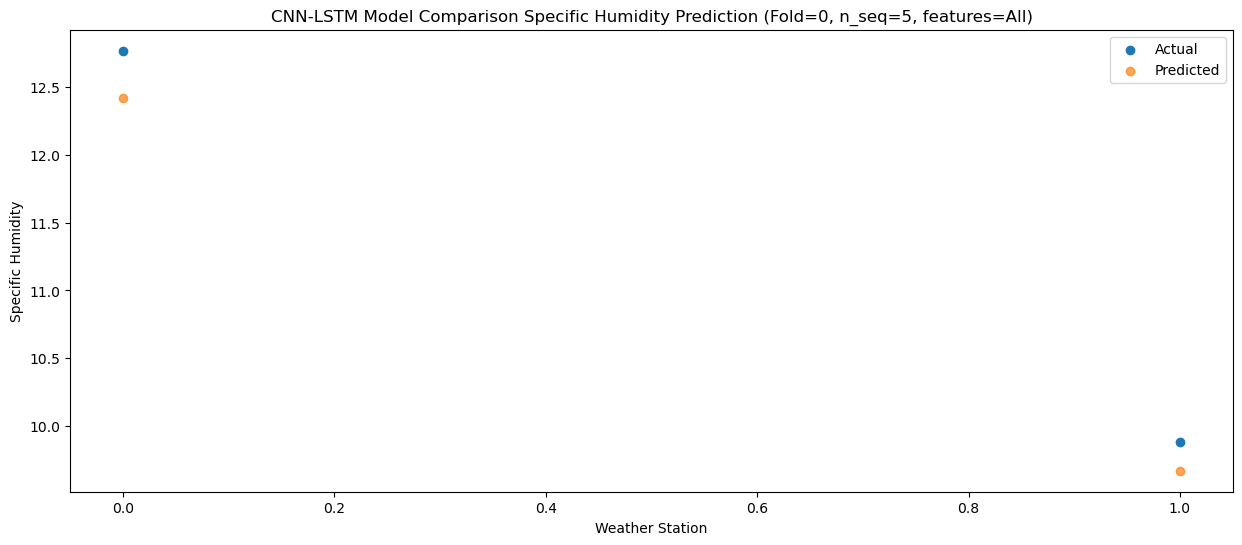

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.359127
1                1   10.09   9.609127


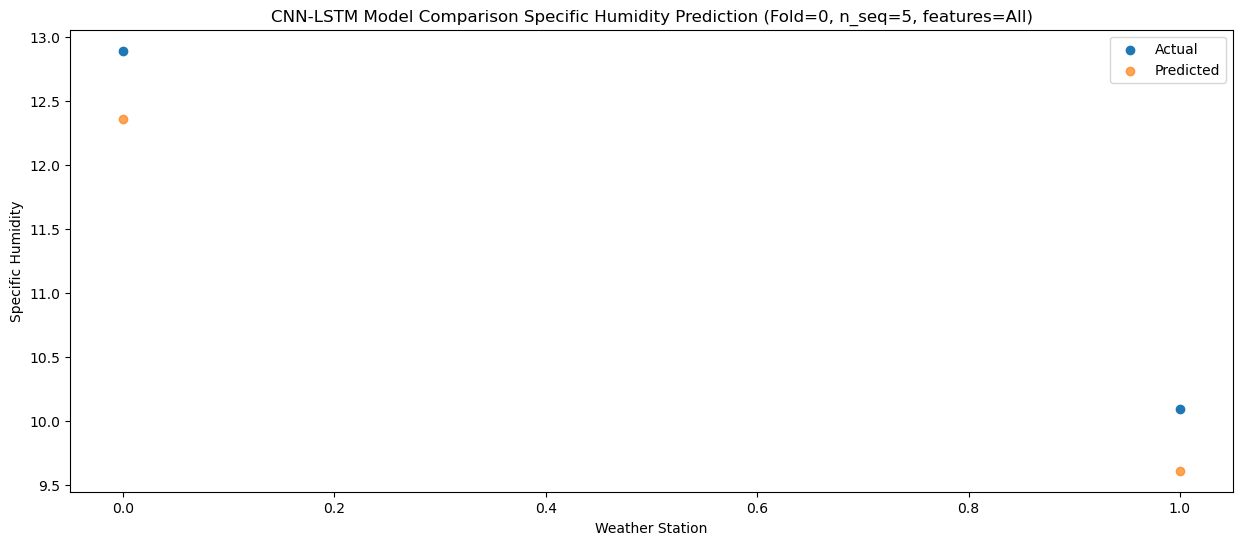

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.473038
1                1    9.65   9.723038


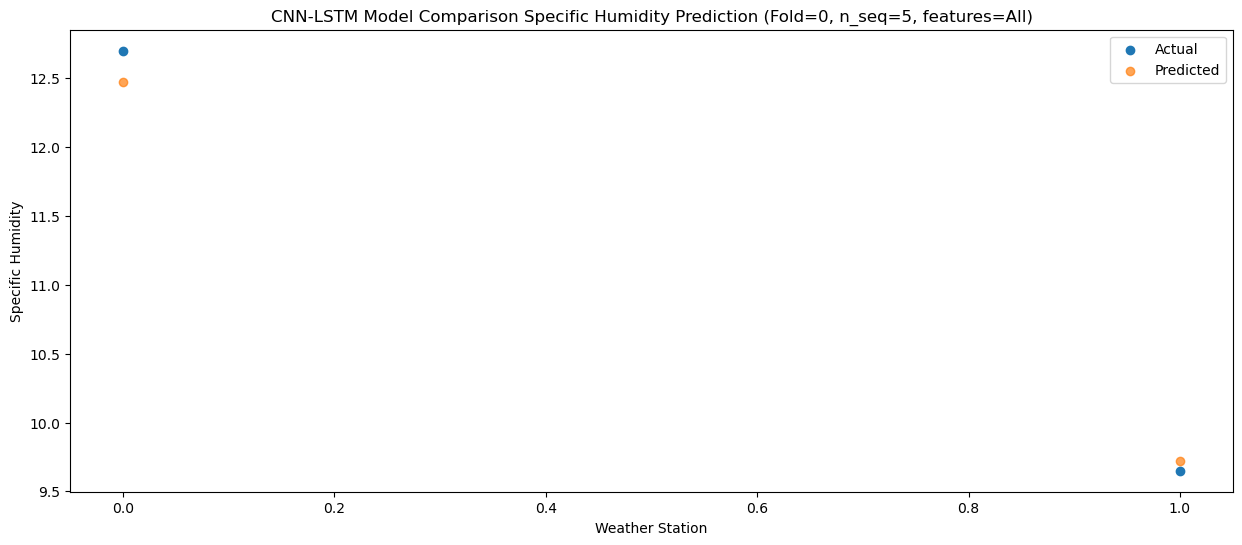

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  12.094729
1                1    9.13   9.344729


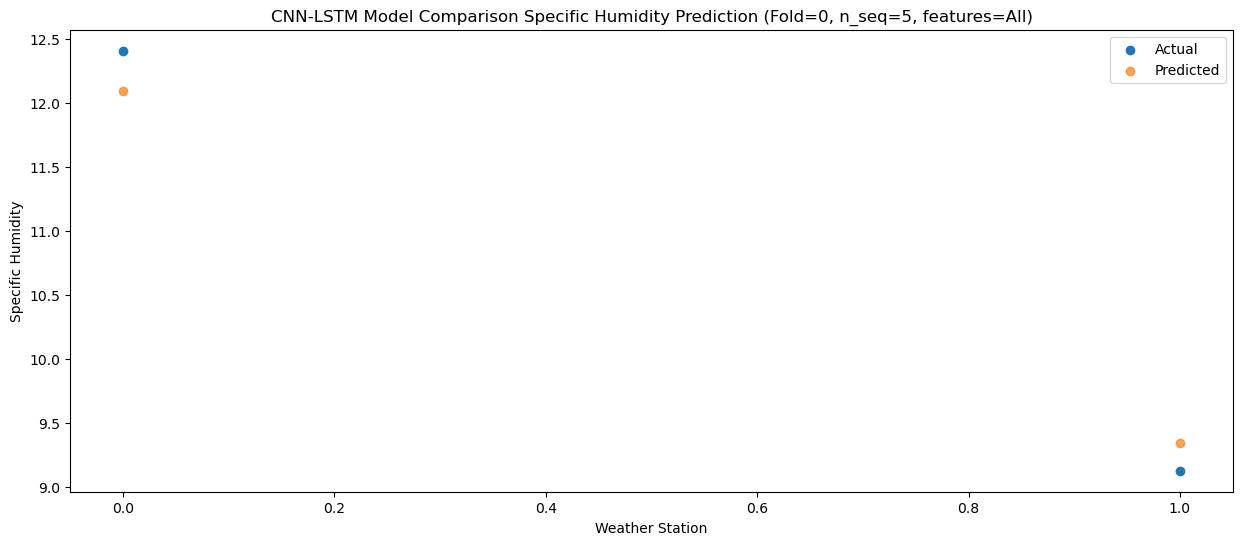

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  12.277135
1                1    9.32   9.527135


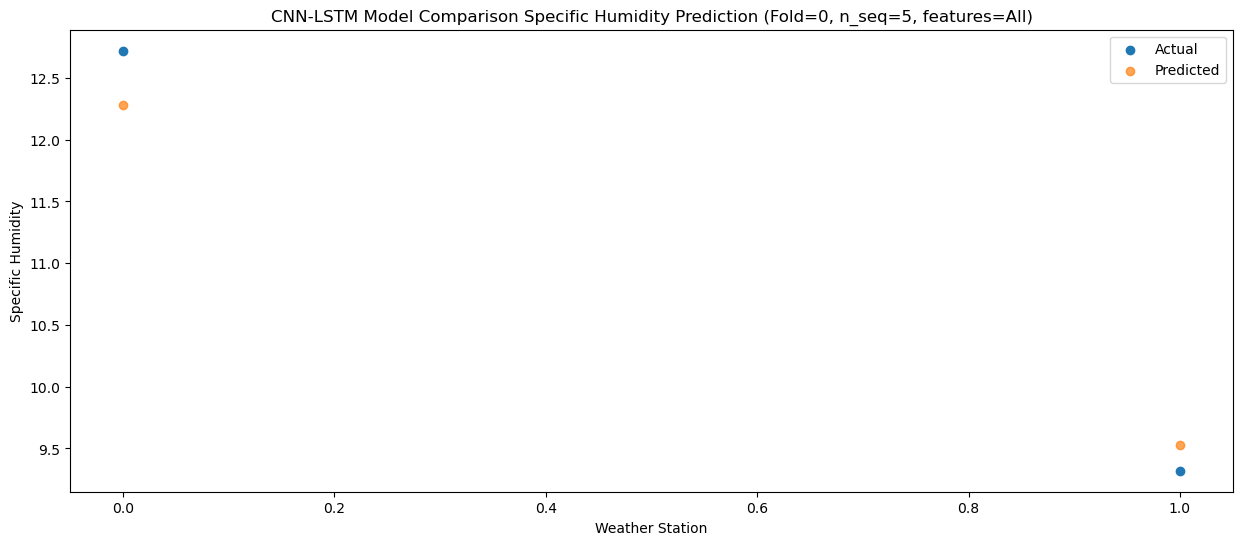

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.41844396  9.66844396]
 [12.35912657  9.60912657]
 [12.4730382   9.7230382 ]
 [12.09472898  9.34472898]
 [12.27713543  9.52713543]]
Year at t+1:
t+1 SKRMSE: 0.290127
t+1 KRMSE: 0.290127
t+1 MAE: 0.281556
t+1 SKMAPE: 0.024471
t+1 R2_SCORE: 0.959687
t+1 KMAPE: 0.024471
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.506491
t+2 KRMSE: 0.506491
t+2 MAE: 0.505873
t+2 SKMAPE: 0.044422
t+2 R2_SCORE: 0.869116
t+2 KMAPE: 0.044422
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.168592
t+3 KRMSE: 0.168592
t+3 MAE: 0.150000
t+3 SKMAPE: 0.012720
t+3 R2_SCORE: 0.987778
t+3 KMAPE: 0.012720
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.269726
t+4 KRMSE: 0.269726
t+4 MAE: 0.265000
t+4 SKMAPE: 0.024462
t+4 R2_SCORE: 0.972951
t+4 KMAPE: 0.024462
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.345

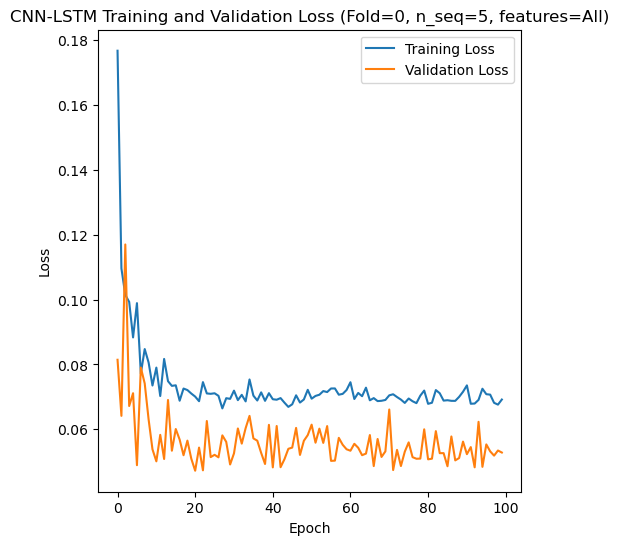

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 30s 397ms/step - loss: 0.1510 - accuracy: 0.2632 - mae: 0.1333 - rmse: 0.1510 - mape: 31.6525 - pearson: 0.2667 - val_loss: 0.0960 - val_accuracy: 0.3333 - val_mae: 0.0797 - val_rmse: 0.0960 - val_mape: 18.8131 - val_pearson: 0.1595
Epoch 2/100
19/19 [==============================] - 2s 112ms/step - loss: 0.1088 - accuracy: 0.3684 - mae: 0.0960 - rmse: 0.1088 - mape: 23.0497 - pearson: 0.3174 - val_loss: 0.1373 - val_accuracy: 0.3333 - val_mae: 0.1043 - val_rmse: 0.1373 - val_mape: 22.2023 - val_pearson: 0.1046
Epoch 3/100
19/19 [==============================] - 4s 187ms/step - loss: 0.1031 - accura

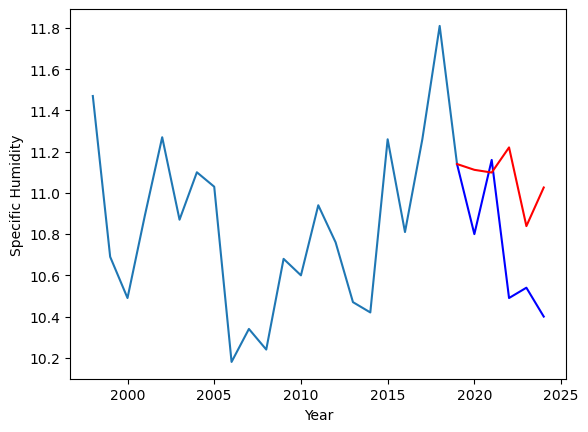

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.27		-0.39
6.92		7.26		0.34
7.36		7.38		0.02
6.79		7.00		0.21
6.94		7.19		0.25


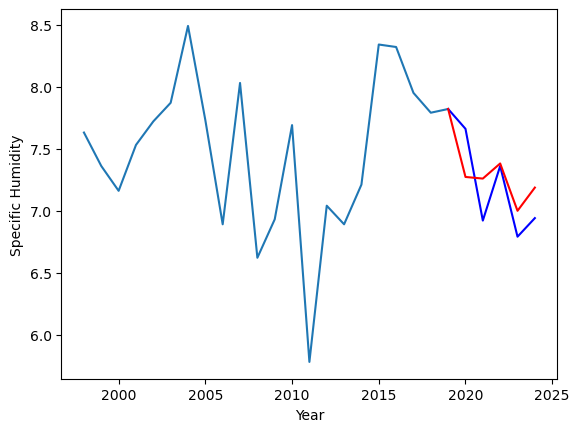

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.111882
1                1    7.66   7.271882


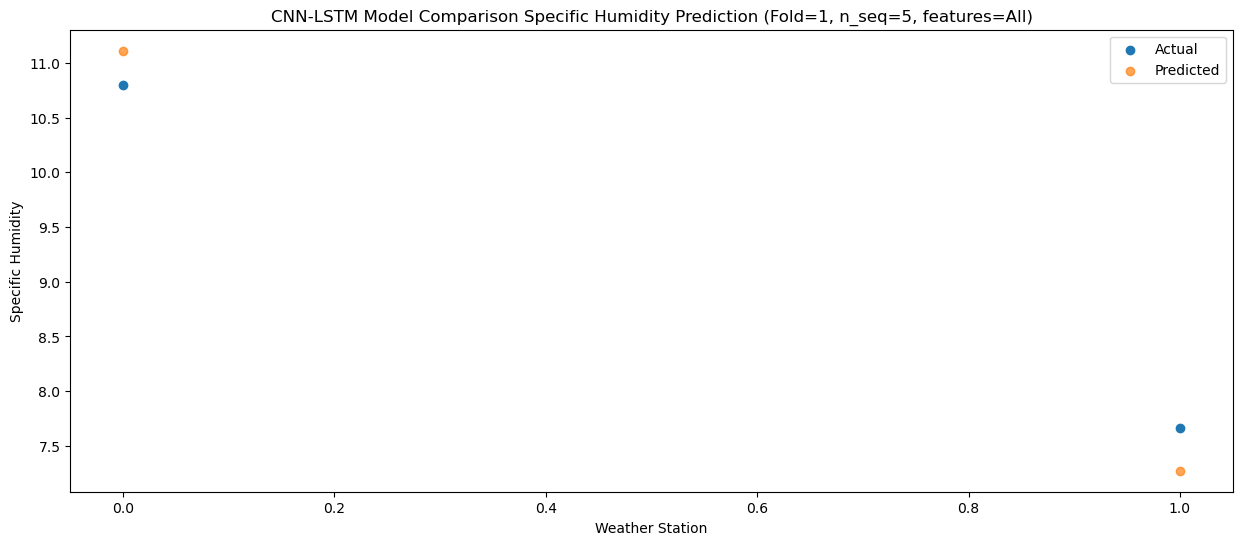

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  11.098756
1                1    6.92   7.258756


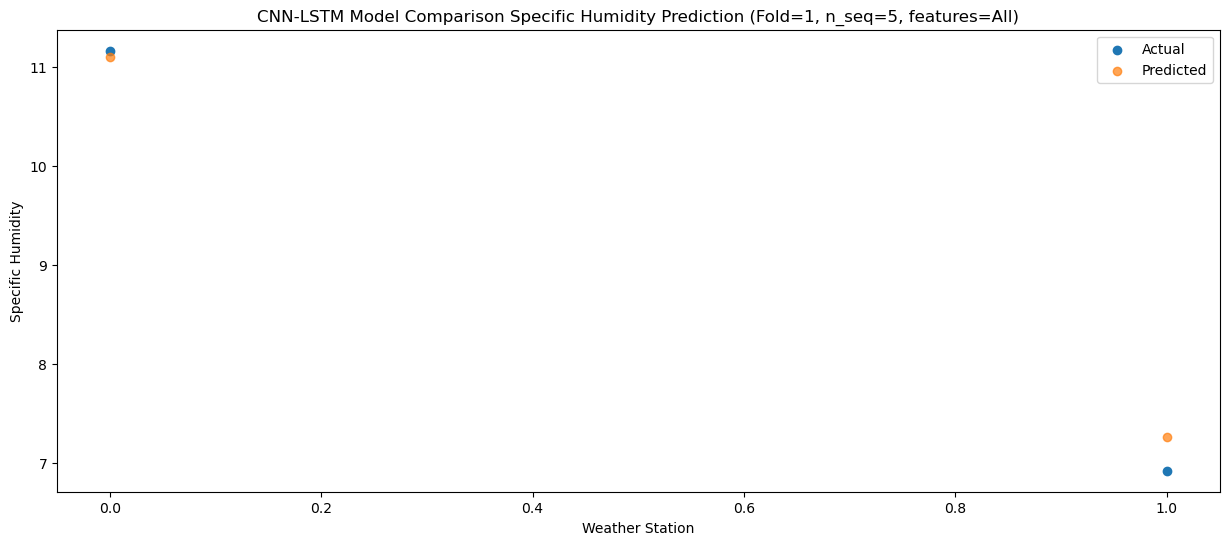

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.220585
1                1    7.36   7.380585


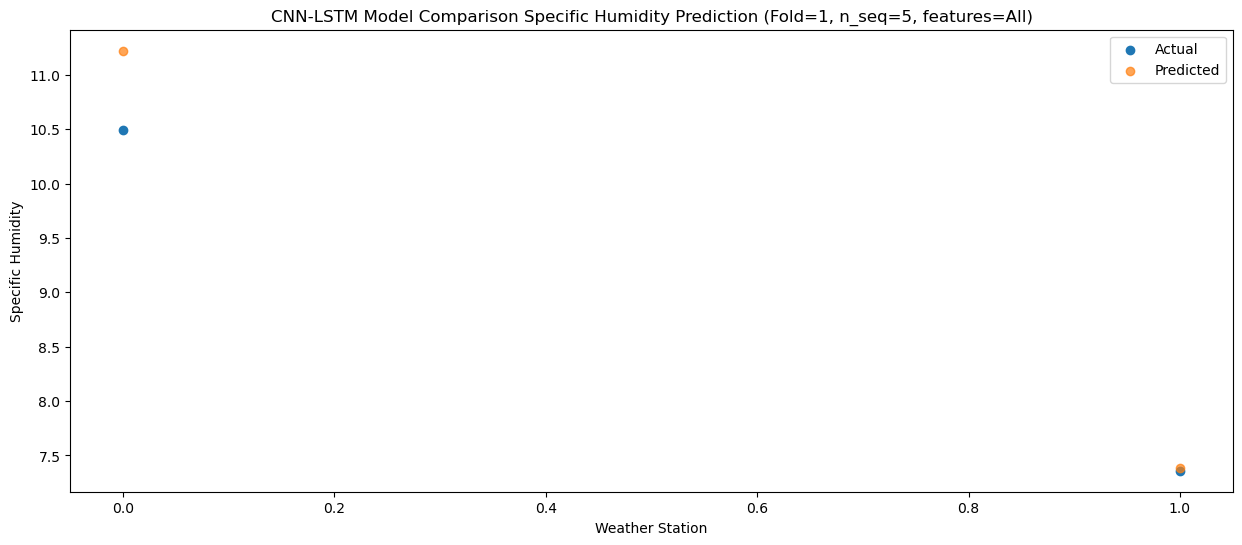

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.838877
1                1    6.79   6.998877


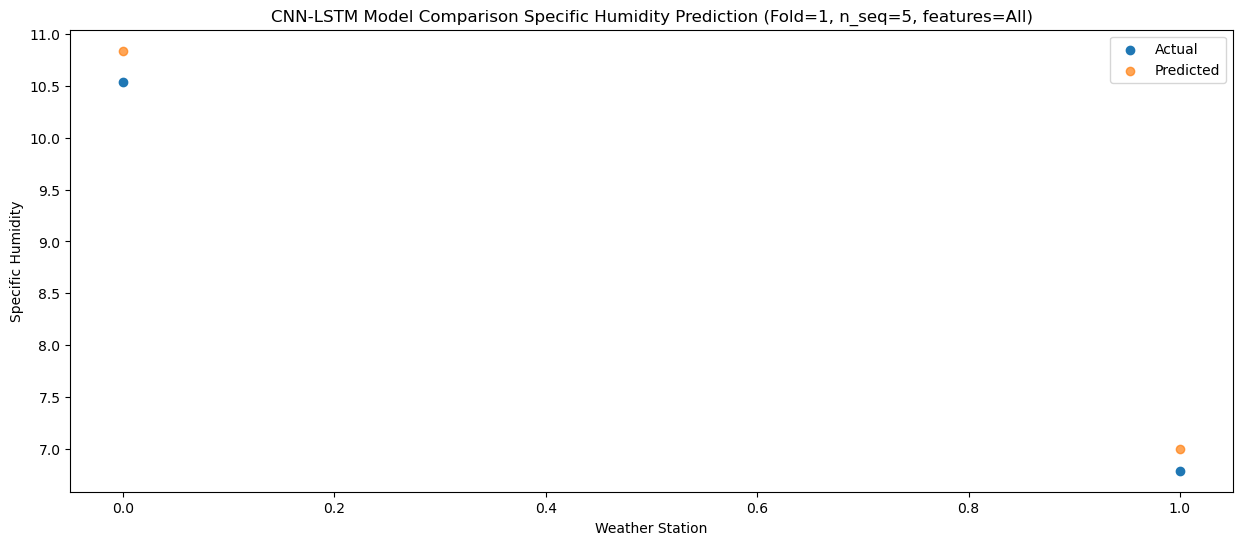

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  11.026138
1                1    6.94   7.186138


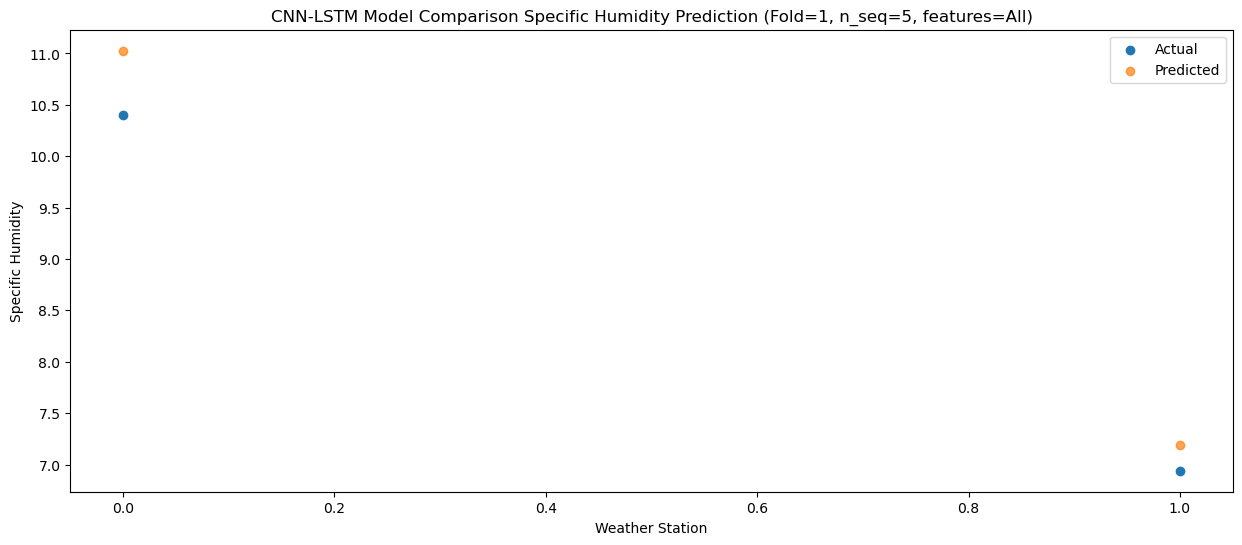

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[11.11188161  7.27188161]
 [11.09875597  7.25875597]
 [11.22058503  7.38058503]
 [10.83887742  6.99887742]
 [11.02613769  7.18613769]]
Year at t+1:
t+1 SKRMSE: 0.352070
t+1 KRMSE: 0.352070
t+1 MAE: 0.350000
t+1 SKMAPE: 0.039773
t+1 R2_SCORE: 0.949713
t+1 KMAPE: 0.039773
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.243420
t+2 KRMSE: 0.243420
t+2 MAE: 0.200000
t+2 SKMAPE: 0.027220
t+2 R2_SCORE: 0.986816
t+2 KMAPE: 0.027220
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.516807
t+3 KRMSE: 0.516807
t+3 MAE: 0.375585
t+3 SKMAPE: 0.036221
t+3 R2_SCORE: 0.890950
t+3 KMAPE: 0.036221
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.257835
t+4 KRMSE: 0.257835
t+4 MAE: 0.253877
t+4 SKMAPE: 0.029559
t+4 R2_SCORE: 0.981090
t+4 KMAPE: 0.029559
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.475727


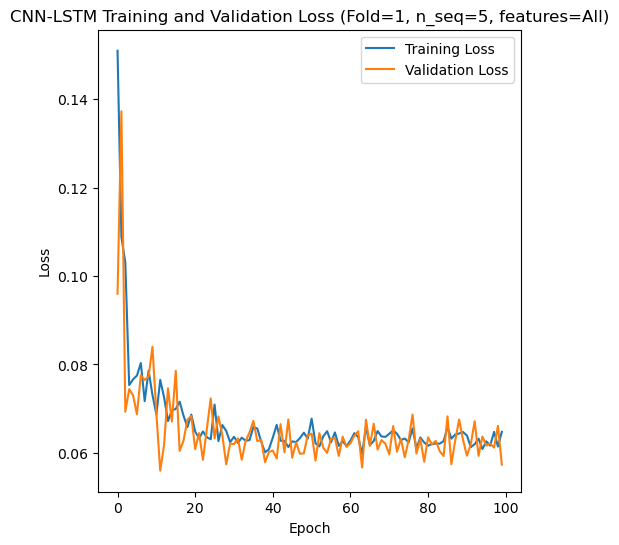

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 21s 357ms/step - loss: 0.1717 - accuracy: 0.3158 - mae: 0.1500 - rmse: 0.1717 - mape: 35.8578 - pearson: 0.2310 - val_loss: 0.0926 - val_accuracy: 0.6667 - val_mae: 0.0821 - val_rmse: 0.0926 - val_mape: 18.7703 - val_pearson: 0.6591
Epoch 2/100
19/19 [==============================] - 4s 205ms/step - loss: 0.1106 - accuracy: 0.2632 - mae: 0.0953 - rmse: 0.1106 - mape: 22.9118 - pearson: 0.2779 - val_loss: 0.0771 - val_accuracy: 0.6667 - val_mae: 0.0701 - val_rmse: 0.0771 - val_mape: 16.6034 - val_pearson: 0.5778
Epoch 3/100
19/19 [==============================] - 3s 162ms/step - loss: 0.0814 - accura

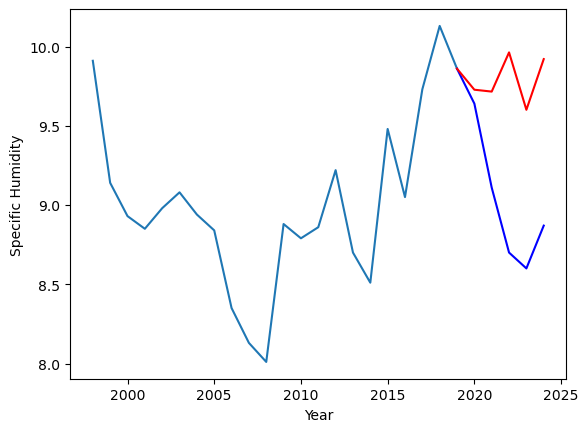

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.31		0.47
7.66		8.30		0.64
7.73		8.54		0.81
8.00		8.18		0.18
8.01		8.50		0.49


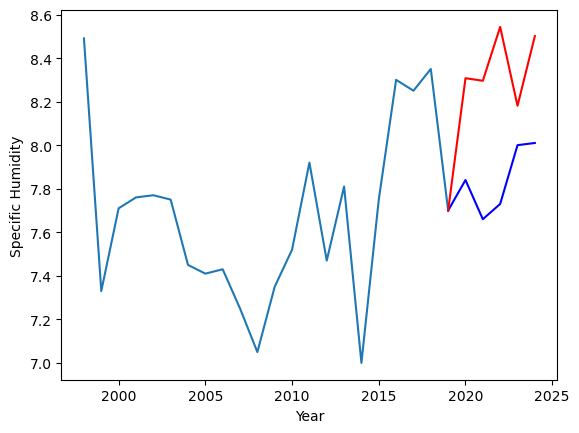

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.727498
1                1    7.84   8.307498


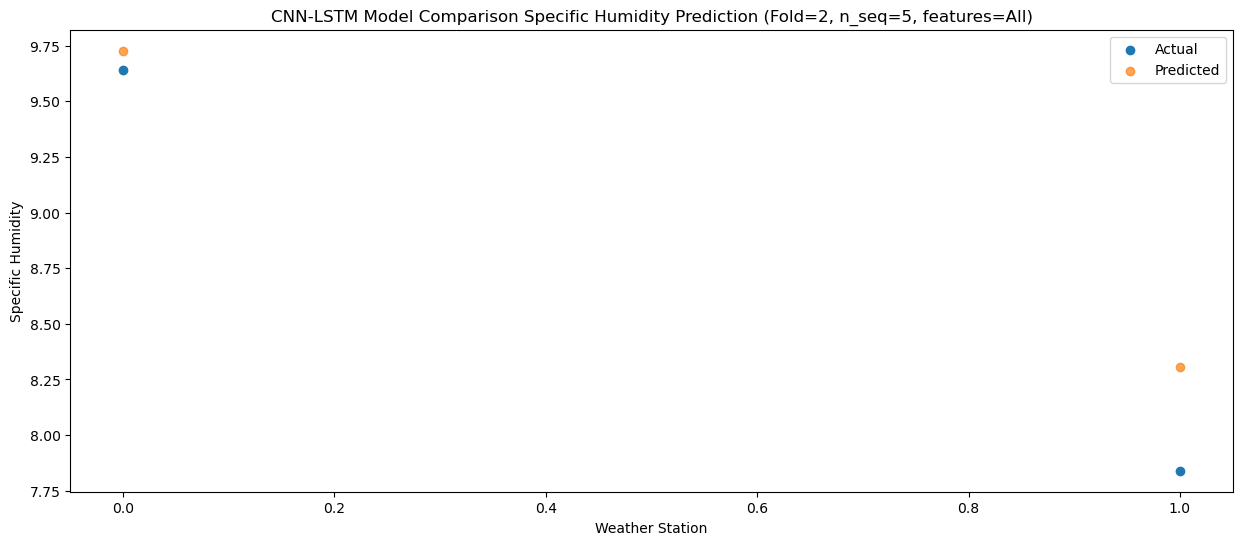

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.715672
1                1    7.66   8.295672


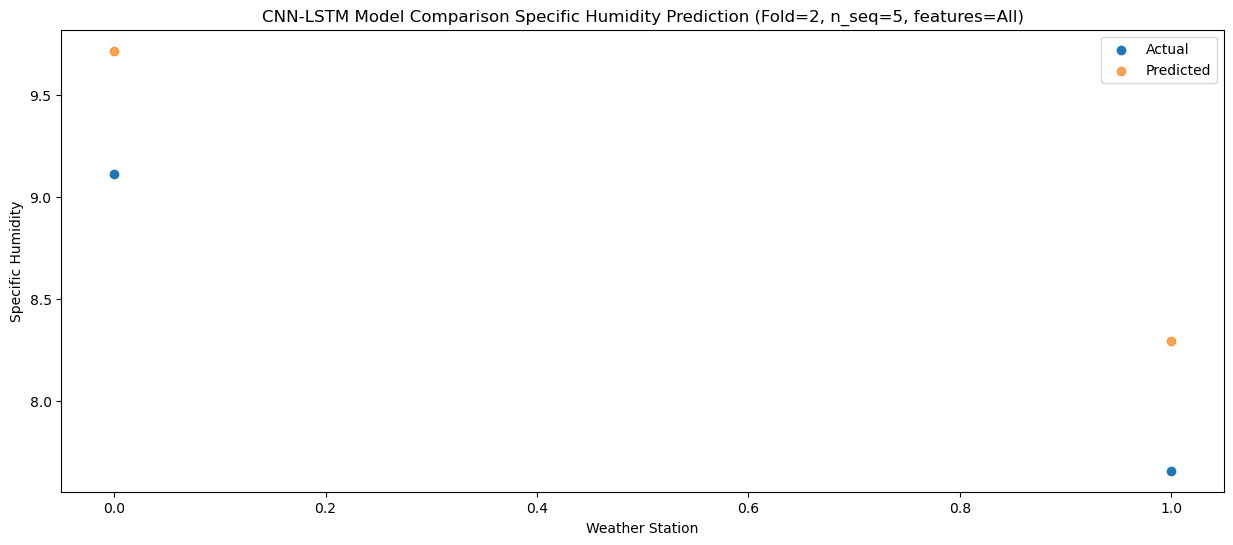

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.962958
1                1    7.73   8.542958


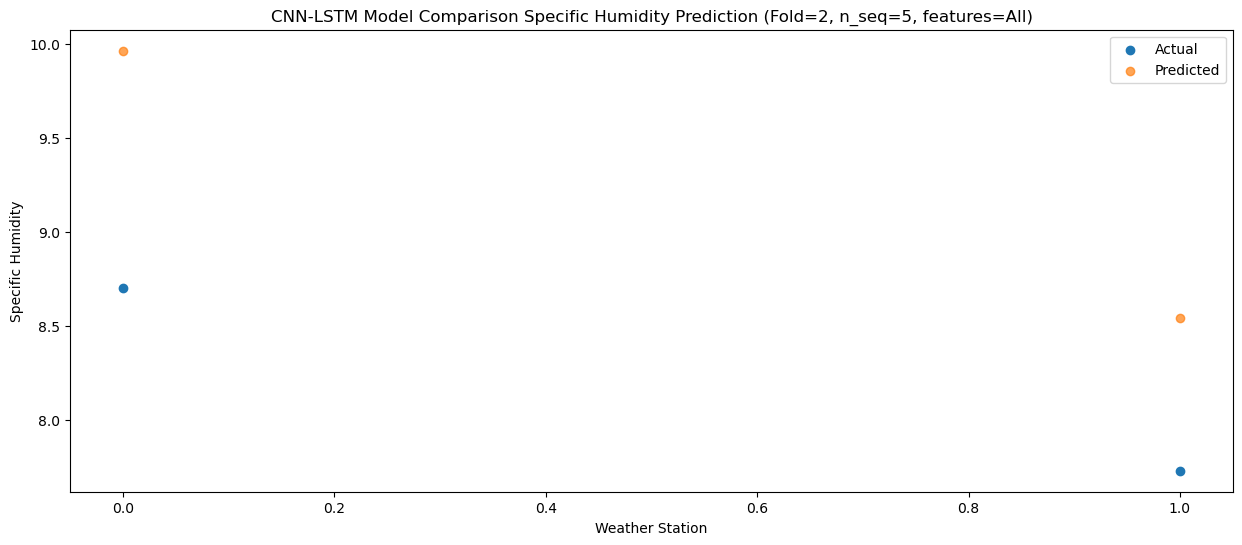

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.600819
1                1     8.0   8.180819


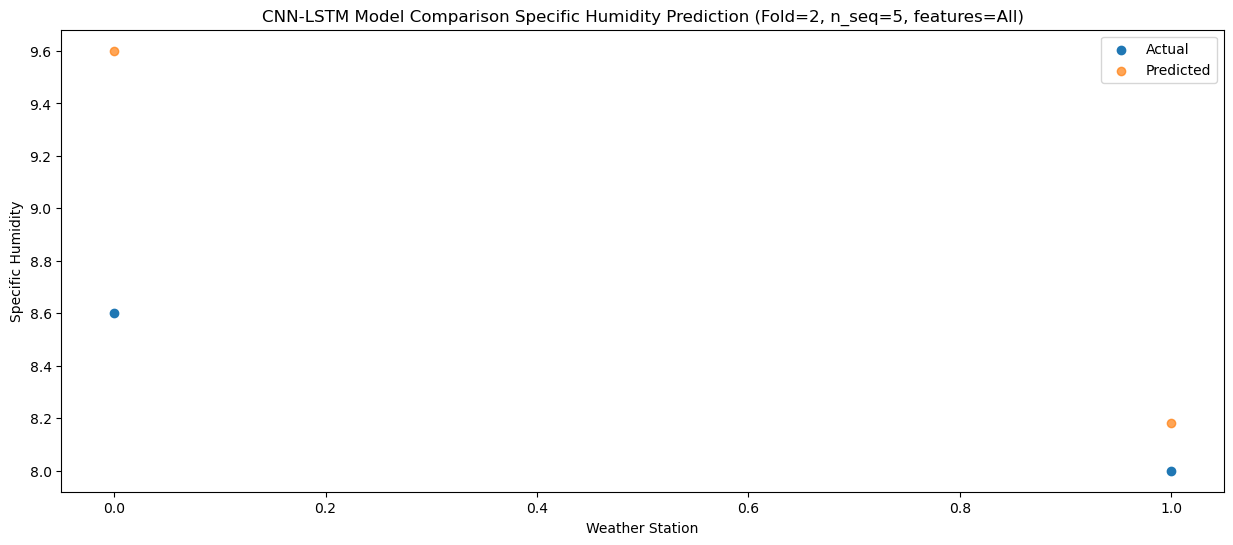

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.920731
1                1    8.01   8.500731


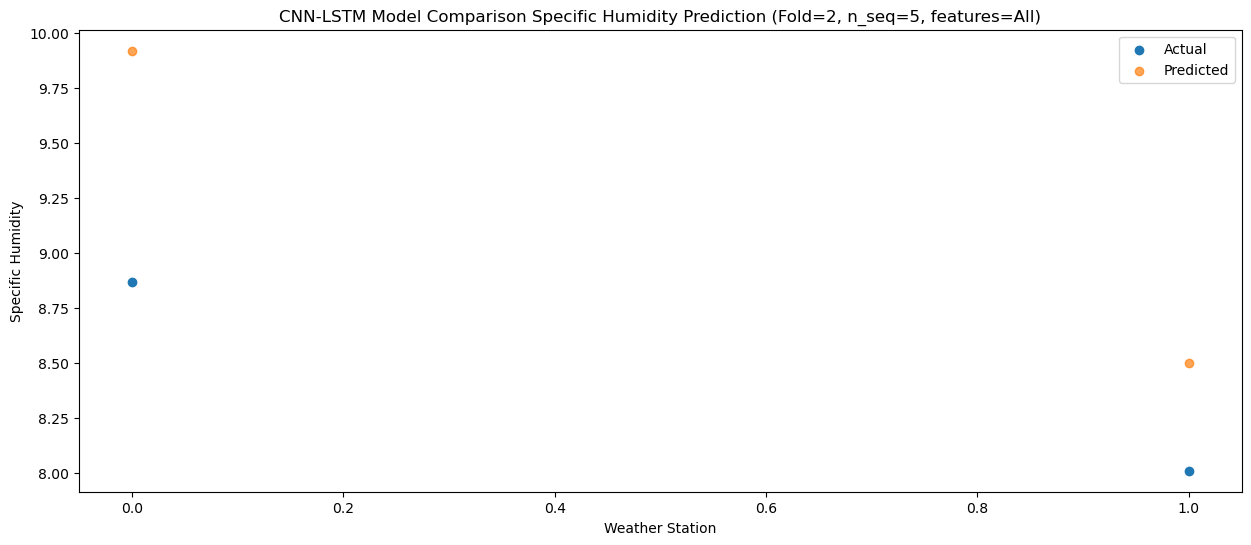

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.72749795 8.30749795]
 [9.71567211 8.29567211]
 [9.96295755 8.54295755]
 [9.60081868 8.18081868]
 [9.92073061 8.50073061]]
Year at t+1:
t+1 SKRMSE: 0.336311
t+1 KRMSE: 0.336311
t+1 MAE: 0.277498
t+1 SKMAPE: 0.034353
t+1 R2_SCORE: 0.860364
t+1 KMAPE: 0.034353
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.620853
t+2 KRMSE: 0.620853
t+2 MAE: 0.620672
t+2 SKMAPE: 0.074735
t+2 R2_SCORE: 0.266666
t+2 KMAPE: 0.074735
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 1.062064
t+3 KRMSE: 1.062064
t+3 MAE: 1.037958
t+3 SKMAPE: 0.125168
t+3 R2_SCORE: -3.795327
t+3 KMAPE: 0.125168
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.719143
t+4 KRMSE: 0.719143
t+4 MAE: 0.590819
t+4 SKMAPE: 0.069488
t+4 R2_SCORE: -4.746297
t+4 KMAPE: 0.069488
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.820016
t+5 KRMSE: 0.82001

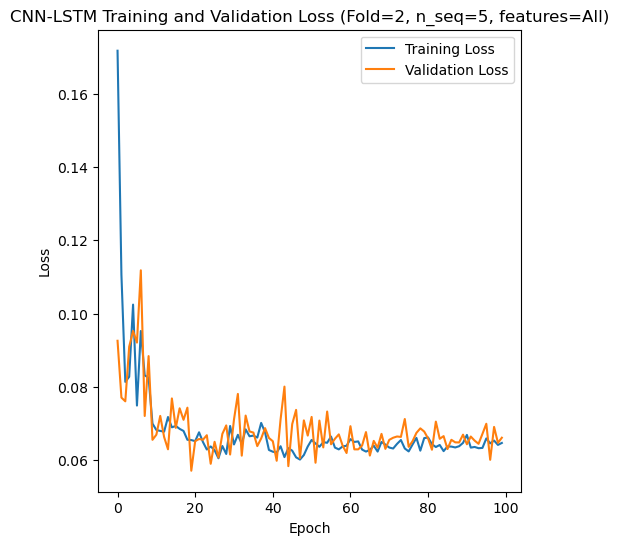

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 21s 289ms/step - loss: 0.2211 - accuracy: 0.2000 - mae: 0.1964 - rmse: 0.2211 - mape: 34.7757 - pearson: 0.2746 - val_loss: 0.2087 - val_accuracy: 0.5000 - val_mae: 0.2038 - val_rmse: 0.2087 - val_mape: 34.3820 - val_pearson: 0.9251
Epoch 2/100
20/20 [==============================] - 2s 81ms/step - loss: 0.2124 - accuracy: 0.2500 - mae: 0.1917 - rmse: 0.2124 - mape: 32.9378 - pearson: 0.3383 - val_loss: 0.0696 - val_accuracy: 0.5000 - val_mae: 0.0581 - val_rmse: 0.0696 - val_mape: 10.4363 - val_pearson: 0.6303
Epoch 3/100
20/20 [==============================] - 2s 84ms/step - loss: 0.1309 - accuracy: 0.2500 - mae: 0.1097 - rmse: 0.1309 - mape: 19.8856 - pe

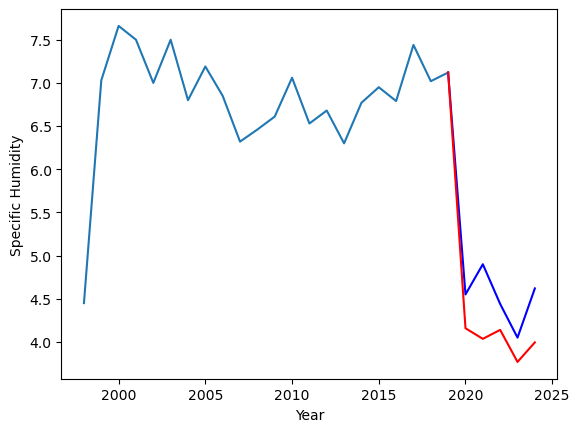

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		8.04		-0.17
8.12		7.92		-0.20
8.09		8.02		-0.07
7.62		7.65		0.03
7.64		7.87		0.23


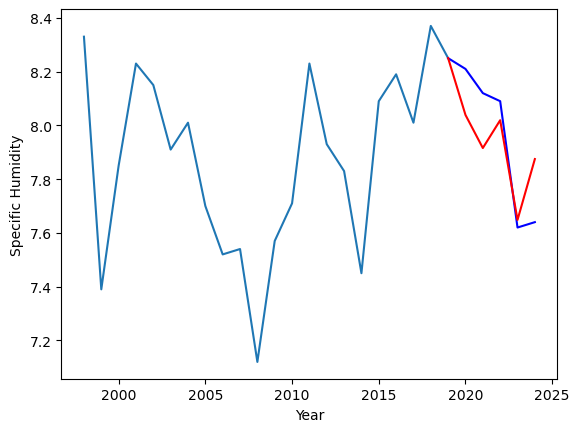

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.158758
1                1    8.21   8.038784


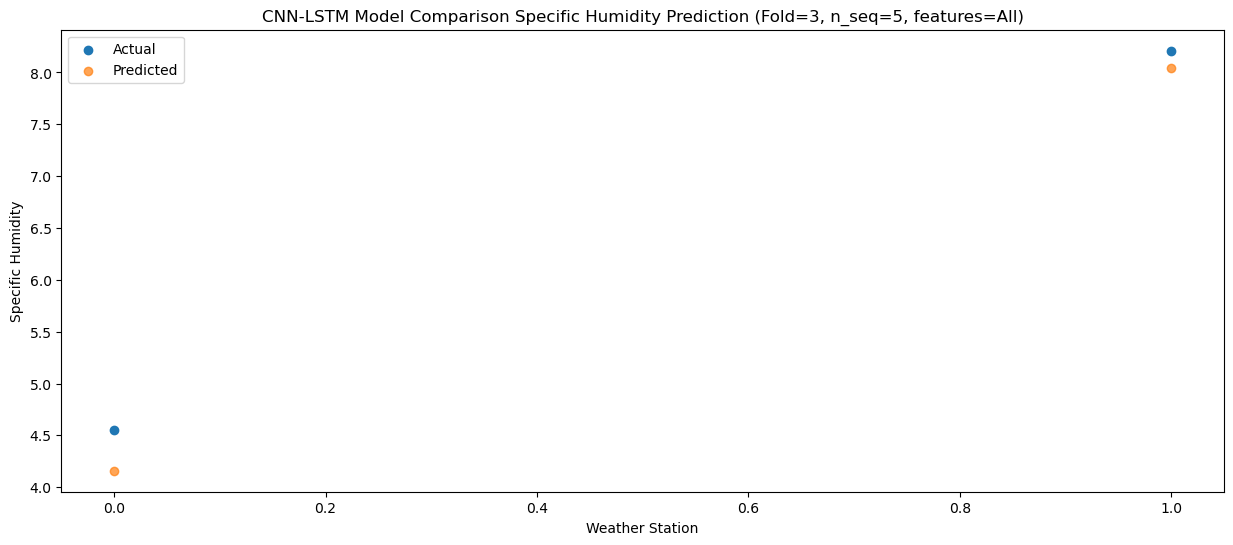

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   4.035935
1                1    8.12   7.915759


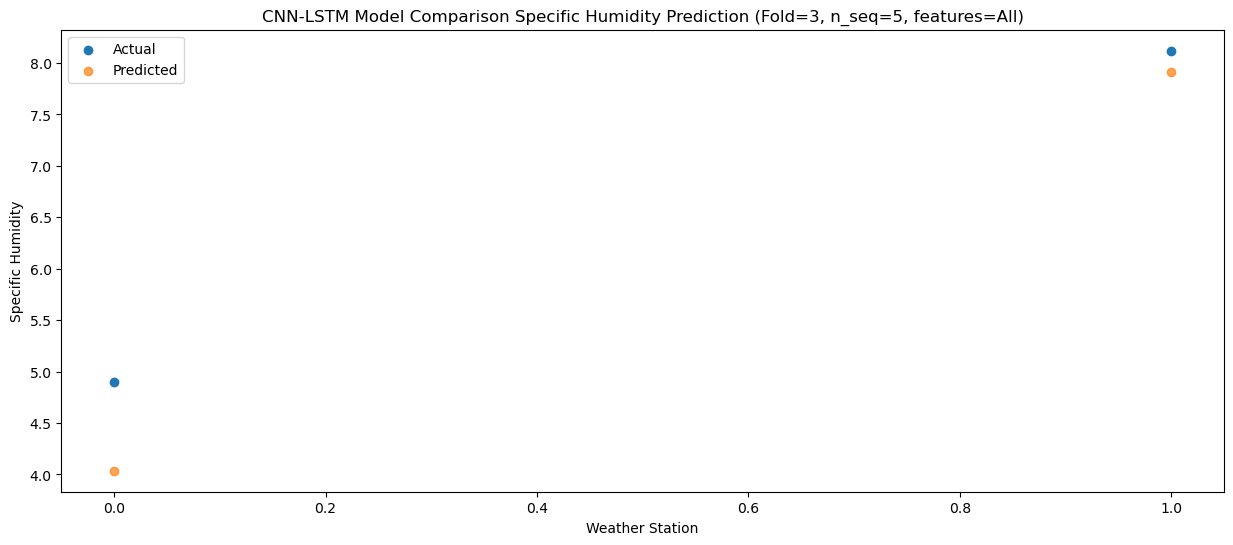

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.139530
1                1    8.09   8.019264


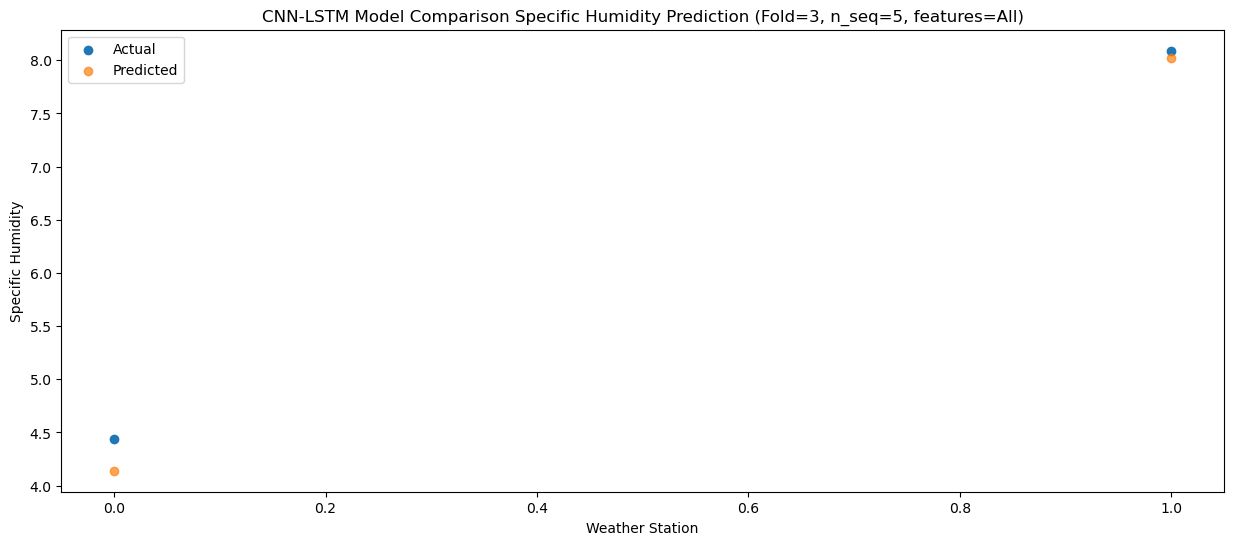

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.768715
1                1    7.62   7.648320


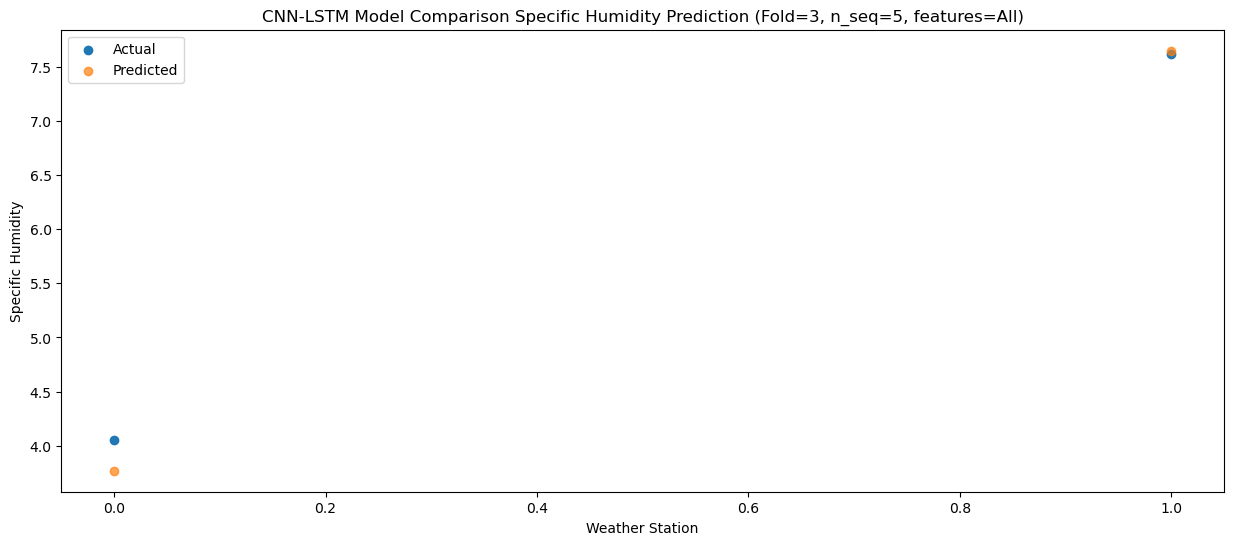

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   3.995237
1                1    7.64   7.874750


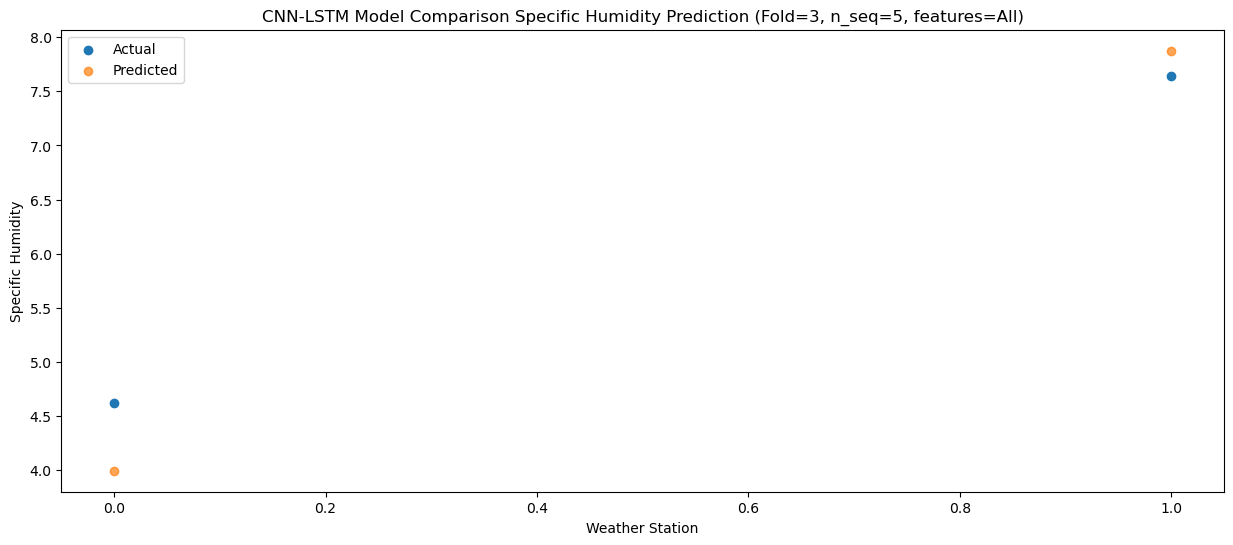

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.15875752 8.03878366]
 [4.03593465 7.91575894]
 [4.13953022 8.01926407]
 [3.76871473 7.64831978]
 [3.99523737 7.87474962]]
Year at t+1:
t+1 SKRMSE: 0.301982
t+1 KRMSE: 0.301982
t+1 MAE: 0.281229
t+1 SKMAPE: 0.053421
t+1 R2_SCORE: 0.972769
t+1 KMAPE: 0.053421
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.627823
t+2 KRMSE: 0.627823
t+2 MAE: 0.534153
t+2 SKMAPE: 0.100746
t+2 R2_SCORE: 0.847937
t+2 KMAPE: 0.100746
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.218272
t+3 KRMSE: 0.218272
t+3 MAE: 0.185603
t+3 SKMAPE: 0.038208
t+3 R2_SCORE: 0.985696
t+3 KMAPE: 0.038208
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.199904
t+4 KRMSE: 0.199904
t+4 MAE: 0.154803
t+4 SKMAPE: 0.036585
t+4 R2_SCORE: 0.987458
t+4 KMAPE: 0.036585
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.471930
t+5 KRMSE: 0.471930


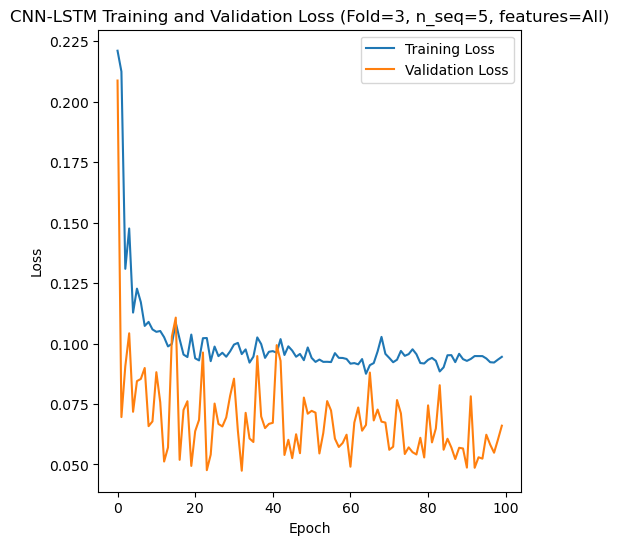

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 36s 443ms/step - loss: 0.1555 - accuracy: 0.2105 - mae: 0.1378 - rmse: 0.1555 - mape: 33.2530 - pearson: 0.2729 - val_loss: 0.0793 - val_accuracy: 0.0000e+00 - val_mae: 0.0688 - val_rmse: 0.0793 - val_mape: 15.7235 - val_pearson: 0.4475
Epoch 2/100
19/19 [==============================] - 2s 98ms/step - loss: 0.1029 - accuracy: 0.3158 - mae: 0.0881 - rmse: 0.1029 - mape: 21.1754 - pearson: 0.3703 - val_loss: 0.1021 - val_accuracy: 0.0000e+00 - val_mae: 0.0877 - val_rmse: 0.1021 - val_mape: 19.2797 - val_pearson: 0.2997
Epoch 3/100
19/19 [==============================] - 2s 108ms/step - loss: 0.0815 - 

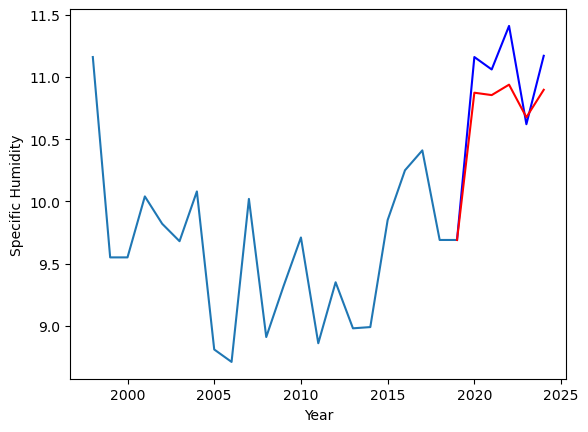

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		8.04		0.25
7.52		8.02		0.50
7.85		8.11		0.26
7.25		7.85		0.60
7.48		8.07		0.59


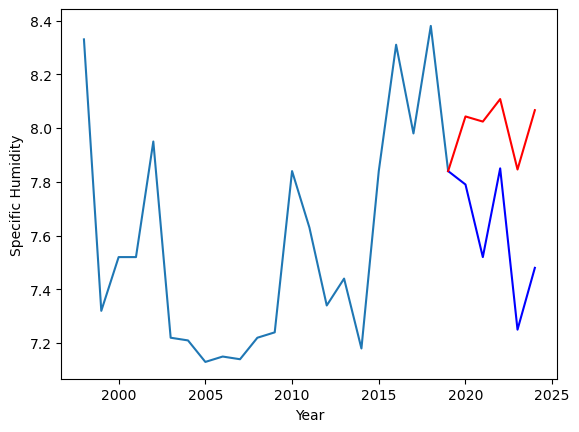

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.873266
1                1    7.79   8.043221


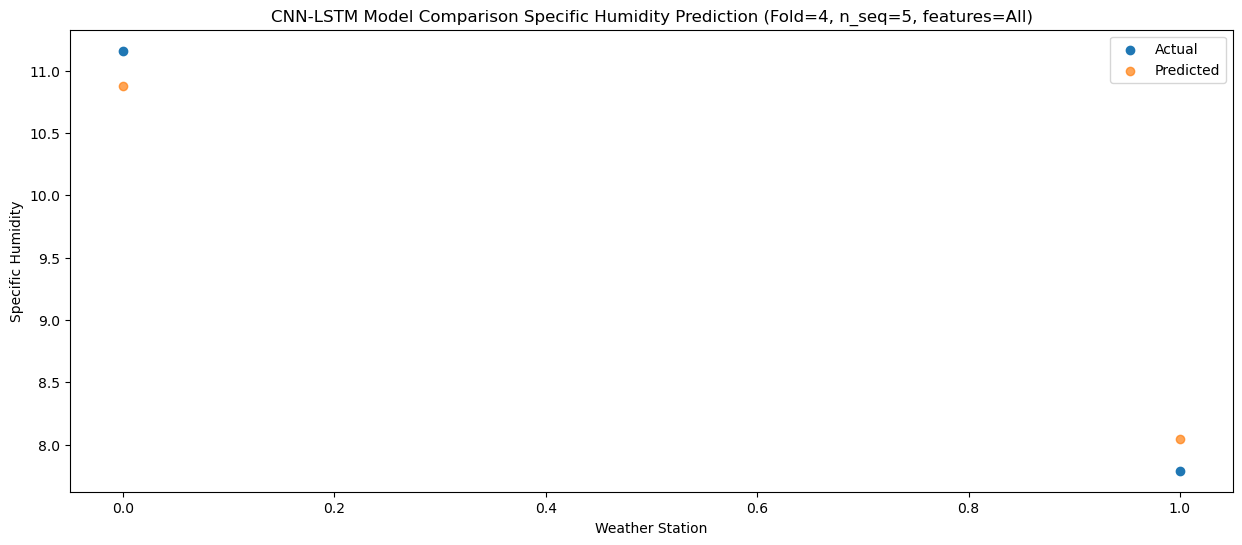

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.854211
1                1    7.52   8.024136


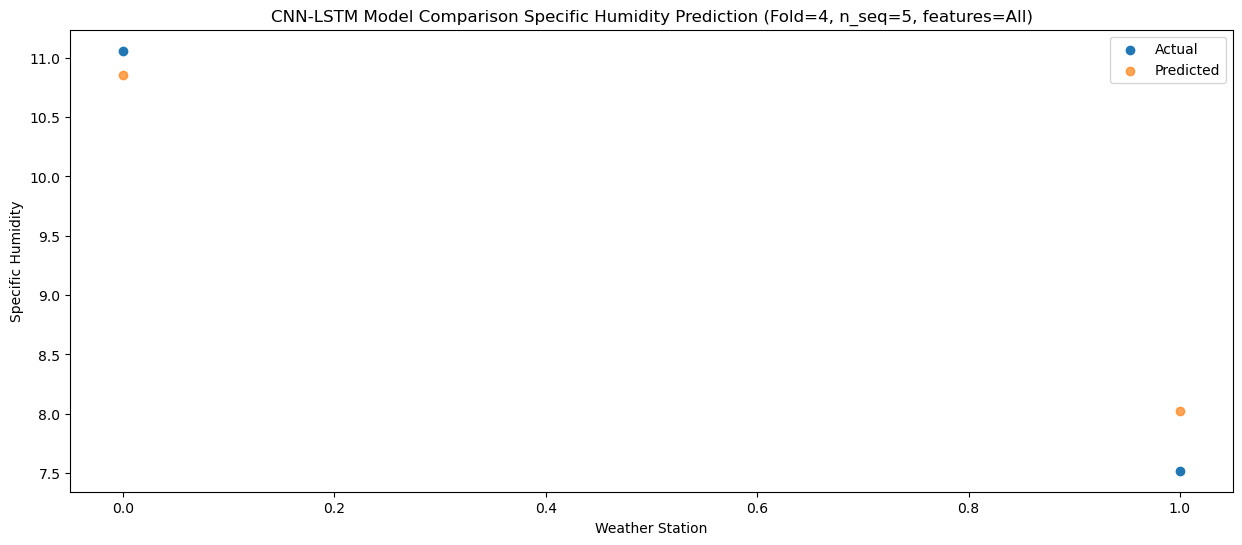

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  10.937932
1                1    7.85   8.107888


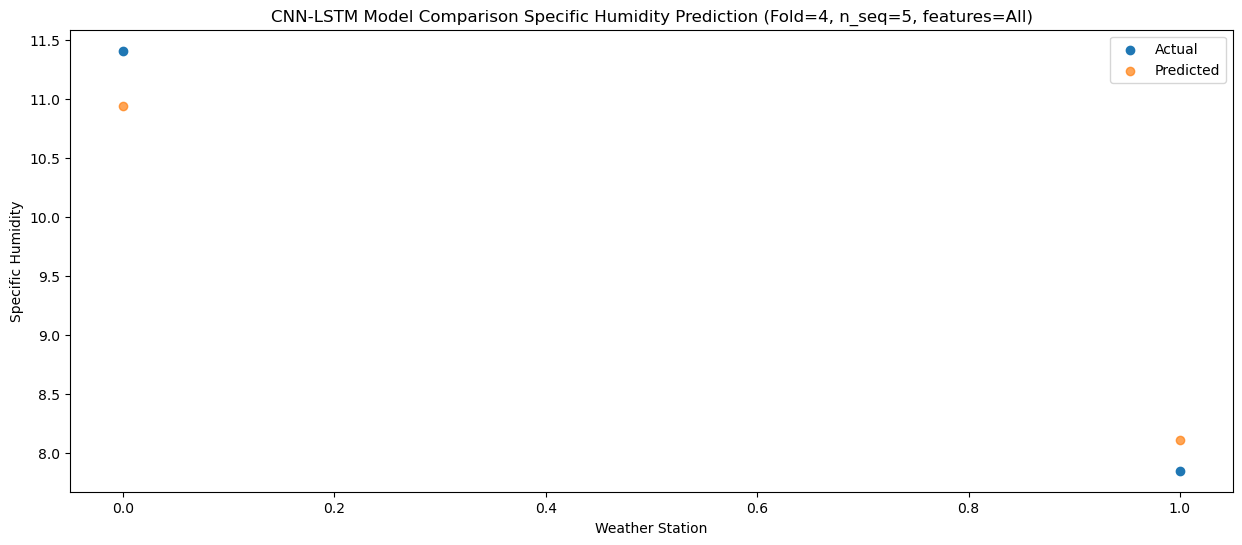

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.675936
1                1    7.25   7.845850


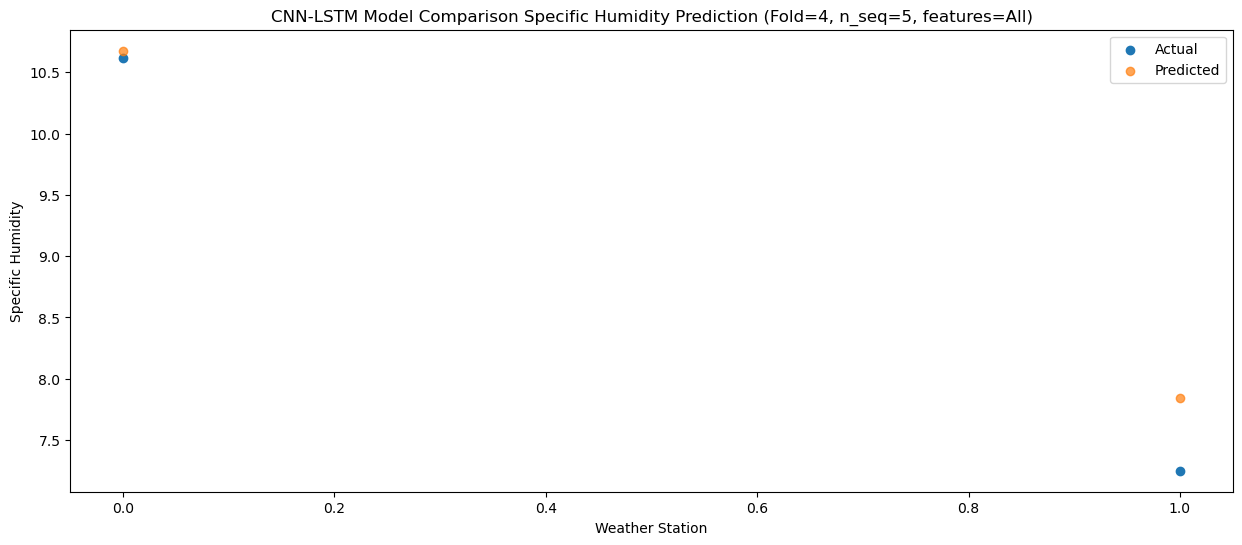

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  10.896756
1                1    7.48   8.066570


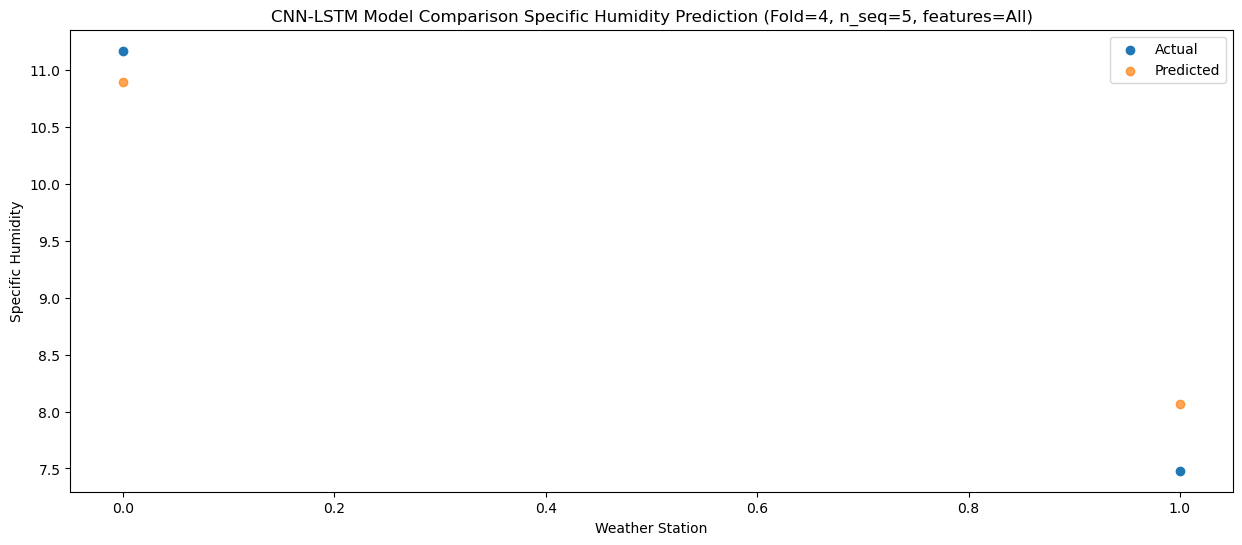

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.87326593  8.04322119]
 [10.85421059  8.02413631]
 [10.93793237  8.10788818]
 [10.67593628  7.84585037]
 [10.89675603  8.06657027]]
Year at t+1:
t+1 SKRMSE: 0.270497
t+1 KRMSE: 0.270497
t+1 MAE: 0.269978
t+1 SKMAPE: 0.029099
t+1 R2_SCORE: 0.974229
t+1 KMAPE: 0.029099
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.385034
t+2 KRMSE: 0.385034
t+2 MAE: 0.354963
t+2 SKMAPE: 0.042823
t+2 R2_SCORE: 0.952679
t+2 KMAPE: 0.042823
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.380364
t+3 KRMSE: 0.380364
t+3 MAE: 0.364978
t+3 SKMAPE: 0.037113
t+3 R2_SCORE: 0.954337
t+3 KMAPE: 0.037113
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.423182
t+4 KRMSE: 0.423182
t+4 MAE: 0.325893
t+4 SKMAPE: 0.043727
t+4 R2_SCORE: 0.936925
t+4 KMAPE: 0.043727
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.457563


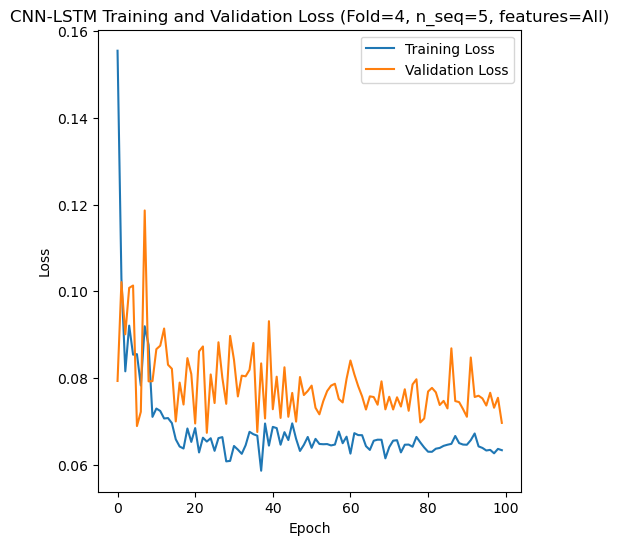

[[0.33508180721230146], [0.3855100965679082], [0.7504848084018914], [0.3989177688426011], [0.38846978493124085]]
[[array(0.33508181)], [array(0.3855101)], [array(0.75048481)], [array(0.39891777)], [array(0.38846978)]]
[[0.30548589545488375], [0.32312002788484107], [0.6595353800952439], [0.3171088247895245], [0.3491437680125239]]
[[0.02691903294376883], [0.03612209208900356], [0.07872135730512406], [0.06238777316718176], [0.04084042531414285]]
[[0.9542134398026207], [0.9539999595905572], [-0.4037730735001508], [0.9469757981188894], [0.9517938654936898]]
[[array(0.02691903)], [array(0.03612209)], [array(0.07872136)], [array(0.06238777)], [array(0.04084043)]]
[[array(0.9836362)], [array(0.97752964)], [array(0.75463282)], [array(0.98697778)], [array(0.99319154)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8.09

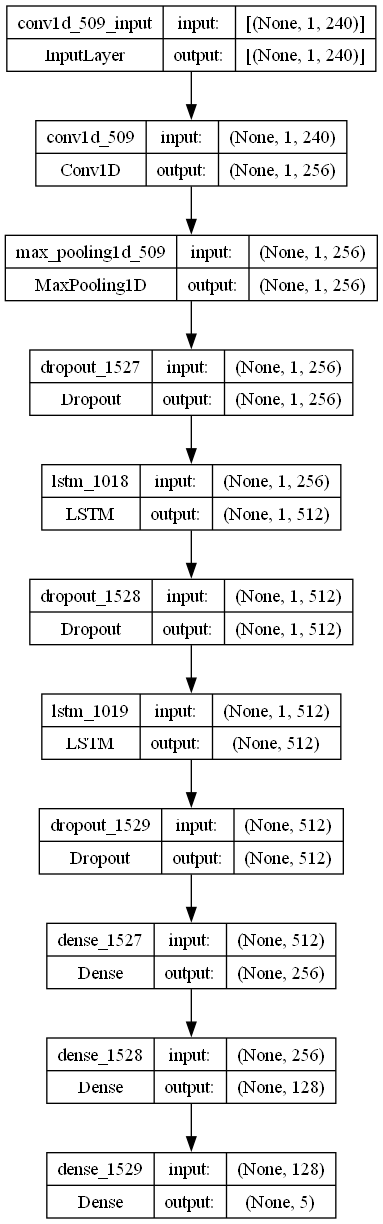

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0018340492826592278
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.14569832363832508

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S5.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)